### some fixes from the last meeting and Ionization parameter analysis.

In [1]:
import pyathena as pa
import numpy as np
import matplotlib.pyplot as plt
from for_hii import hii

from pathlib import Path
import matplotlib as mpl
from astropy import units as au
import yt

from astropy import constants as const
from add_fields_hii import add_fields
import yt.units as yu
from scipy.optimize import curve_fit
from Make_figure import *
import pickle
import os
#mpl.rcParams['figure.figsize'] = (8, 6)
#mpl.rcParams['xtick.top'] = True
#mpl.rcParams['ytick.right'] = True
yt.set_log_level(50)

In [2]:
path='/gpfs/ckswls1699/grammar/Nx192/'
datapath=Path(path)
M5=list(datapath.glob('*M5*'))
M6=list(datapath.glob('*M6*'))
M5.sort()
M6.sort()
M5,M6

([PosixPath('/gpfs/ckswls1699/grammar/Nx192/hii_Q50.0n1.0M5'),
  PosixPath('/gpfs/ckswls1699/grammar/Nx192/hii_Q50.25n1.5M5'),
  PosixPath('/gpfs/ckswls1699/grammar/Nx192/hii_Q50.5n2.0M5'),
  PosixPath('/gpfs/ckswls1699/grammar/Nx192/hii_Q50.75n2.5M5'),
  PosixPath('/gpfs/ckswls1699/grammar/Nx192/hii_Q51.0n3.0M5'),
  PosixPath('/gpfs/ckswls1699/grammar/Nx192/hii_Q51.25n3.5M5')],
 [PosixPath('/gpfs/ckswls1699/grammar/Nx192/hii_Q51.0n1.0M6'),
  PosixPath('/gpfs/ckswls1699/grammar/Nx192/hii_Q51.25n1.5M6'),
  PosixPath('/gpfs/ckswls1699/grammar/Nx192/hii_Q51.5n2.0M6'),
  PosixPath('/gpfs/ckswls1699/grammar/Nx192/hii_Q51.75n2.5M6'),
  PosixPath('/gpfs/ckswls1699/grammar/Nx192/hii_Q52.0n3.0M6'),
  PosixPath('/gpfs/ckswls1699/grammar/Nx192/hii_Q52.25n3.5M6')])

### 1. must we measure ouflow rate considering some inflow region?

In [3]:
## function to calculate ouflow respectly for vr>0 and vr<0
def outflow_divide(model, nums=None):
    s=pa.LoadSim(str(model))
    h=pa.read_hst(s.files['hst'])
    
## select some snapshots for calculation=============================
    if nums == None:
        nums=range(20,181,20)
    t_arr,Mip_out,Mim_out,Pip_out,Pim_out,Om_out=[],[],[],[],[],[]
    for num in nums:
## data load ======================================================
        ds=s.load_hdf5(num,load_method='yt')
        add_fields(ds,s)
        ad=ds.all_data()
        r0=s.par['problem']['r0']*s.par['problem']['revap_over_r0']
        sp=ds.sphere([0,0,0],1.05*r0)
        surf_=ds.surface(sp,'radius',r0)
        surf = surf_.triangles
        w1 = surf[:,1] - surf[:,0]
        w2 = surf[:,1] - surf[:,2]
        vector_area=np.cross(w1, w2)/2
        scalar_area=np.sqrt(np.sum(vector_area**2,axis=1))
        Omega=scalar_area/r0**2
        vr=surf_['vr']
        x,y,z=surf_['x'],surf_['y'],surf_['z']
        rho=surf_['density_ion']
## calculation flux for two surfaces, which have vr>0 and vr<0, respectively=========================
## mass outflow====================================
        dFlux=rho*vr*scalar_area*yu.pc**2
        dFlux=dFlux.to('code_mass/code_time')
        Mim_out.append(np.sum(dFlux[vr<0]))
        Mip_out.append(np.sum(dFlux[vr>0]))
## momentum outflow==========================================
        dFlux=rho*vr*vr*scalar_area*yu.pc**2
        dFlux=dFlux.to('code_mass*code_length/code_time**2')
        Pim_out.append(np.sum(dFlux[vr<0]))
        Pip_out.append(np.sum(dFlux[vr>0]))
        t_arr.append(ds.current_time)
        Om_out.append(np.sum(Omega[vr>0])/np.sum(Omega))
    return t_arr,Mip_out,Mim_out,Pip_out,Pim_out,Om_out

<>:9: SyntaxWarning: invalid escape sequence '\d'
<>:10: SyntaxWarning: invalid escape sequence '\d'
<>:11: SyntaxWarning: invalid escape sequence '\d'
<>:13: SyntaxWarning: invalid escape sequence '\d'
<>:16: SyntaxWarning: invalid escape sequence '\d'
<>:17: SyntaxWarning: invalid escape sequence '\d'
<>:18: SyntaxWarning: invalid escape sequence '\d'
<>:19: SyntaxWarning: invalid escape sequence '\d'
<>:22: SyntaxWarning: invalid escape sequence '\d'
<>:23: SyntaxWarning: invalid escape sequence '\d'
<>:24: SyntaxWarning: invalid escape sequence '\d'
<>:28: SyntaxWarning: invalid escape sequence '\O'
<>:9: SyntaxWarning: invalid escape sequence '\d'
<>:10: SyntaxWarning: invalid escape sequence '\d'
<>:11: SyntaxWarning: invalid escape sequence '\d'
<>:13: SyntaxWarning: invalid escape sequence '\d'
<>:16: SyntaxWarning: invalid escape sequence '\d'
<>:17: SyntaxWarning: invalid escape sequence '\d'
<>:18: SyntaxWarning: invalid escape sequence '\d'
<>:19: SyntaxWarning: invalid esc

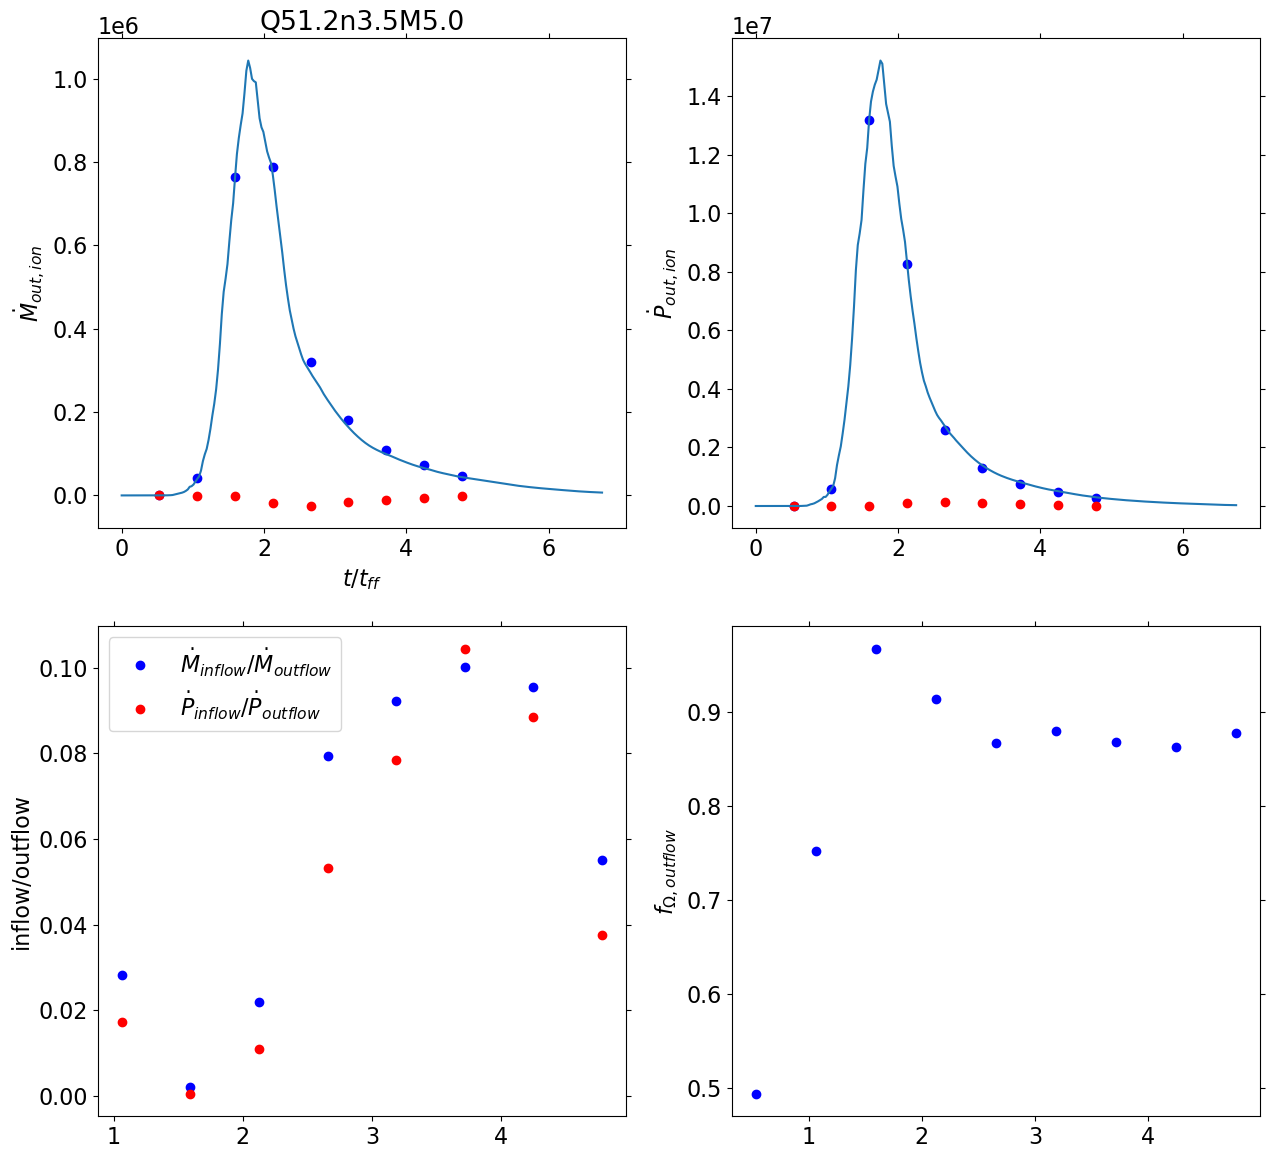

In [27]:
for model in M5[-1:]:
    fig,axes=plt.subplots(2,2,figsize=(15,14))
## data load ==============================================================
## model is Q51.25n3.5M5, where we observed wide region of negative outflow.
    hd=load_hd(str(model))
    t_arr,Mip_out,Mim_out,Pip_out,Pim_out,f_Om=outflow_divide(model)
    t_ff=t_ff_(str(model))
## plot mass outflow for positive/negative vr surfaces=============================
    axes[0][0].plot(t_arr/t_ff,Mip_out,'bo',label='$\dot{M}_{out}(v_r>0)$')
    axes[0][0].plot(t_arr/t_ff,Mim_out,'ro',label='$\dot{M}_{out}(v_r<0)$')
    axes[0][0].plot(hd['time']/t_ff,hd['M_out_ion'],label='$\dot{M}_{out}$')
    axes[0][0].set_xlabel('$t/t_{ff}$')
    axes[0][0].set_ylabel('$\dot{M}_{out,ion}$')
    axes[0][0].set_title(title_(str(model),['Q','n','M']))
## plot radial momentum outflow for positive/negative vr surfaces=============================
    axes[0][1].plot(t_arr/t_ff,Pip_out,'bo',label='$\dot{P}_{out}(v_r>0)$')
    axes[0][1].plot(t_arr/t_ff,Pim_out,'ro',label='$\dot{P}_{out}(v_r<0)$')
    axes[0][1].plot(hd['time']/t_ff,hd['P_out_ion'],label='$\dot{P}_{out}$')
    axes[0][1].set_ylabel('$\dot{P}_{out,ion}$')
    
## plot the ratio between positive and negativ outflow
    axes[1][0].plot(t_arr/t_ff,-np.array(Mim_out)/np.array(Mip_out),'bo',label='$\dot{M}_{inflow}/\dot{M}_{outflow}$')
    axes[1][0].plot(t_arr/t_ff,np.array(Pim_out)/np.array(Pip_out),'ro',label='$\dot{P}_{inflow}/\dot{P}_{outflow}$')
    axes[0][1].set_ylabel('$\dot{P}_{out,ion}$')
    axes[1][0].set_ylabel('inflow/outflow')
    axes[1][0].legend()
    axes[1][1].plot(t_arr/t_ff,f_Om,'bo')
    axes[1][1].set_ylabel('$f_{\Omega,outflow}$')

### inflow seems too small so that we can ignore it.

## data load

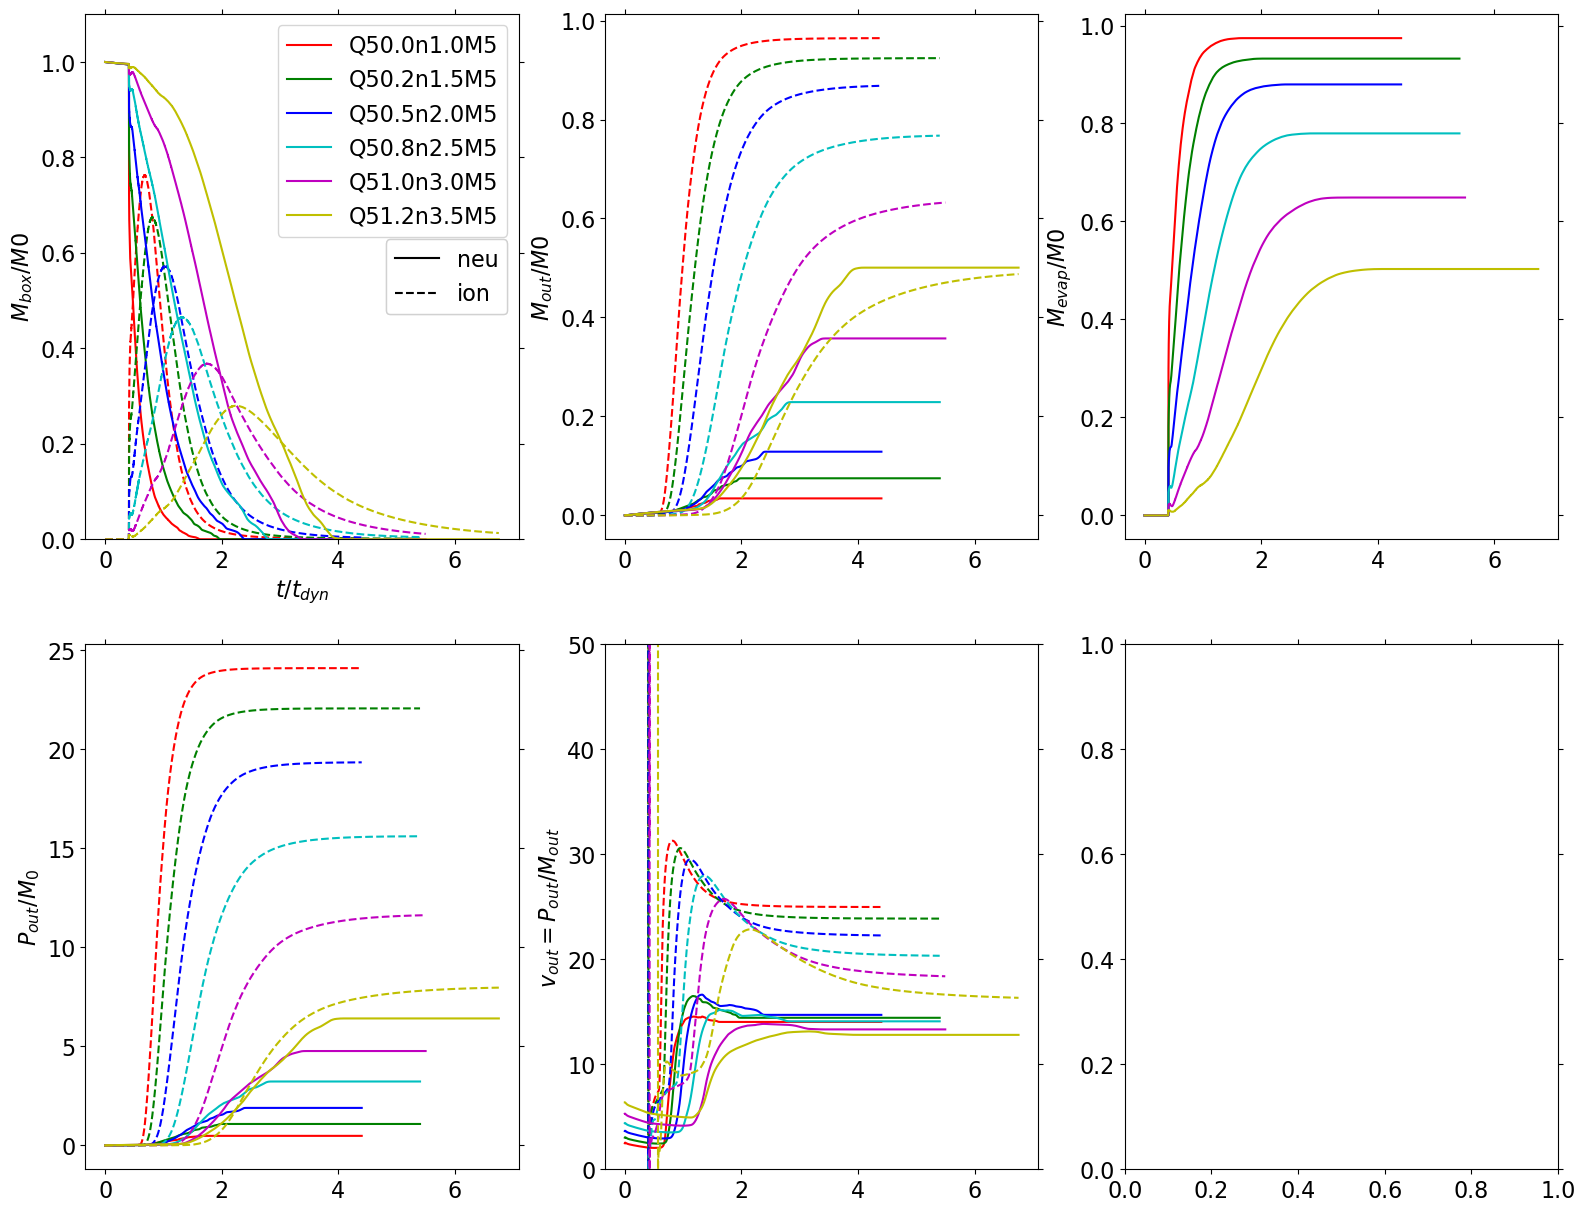

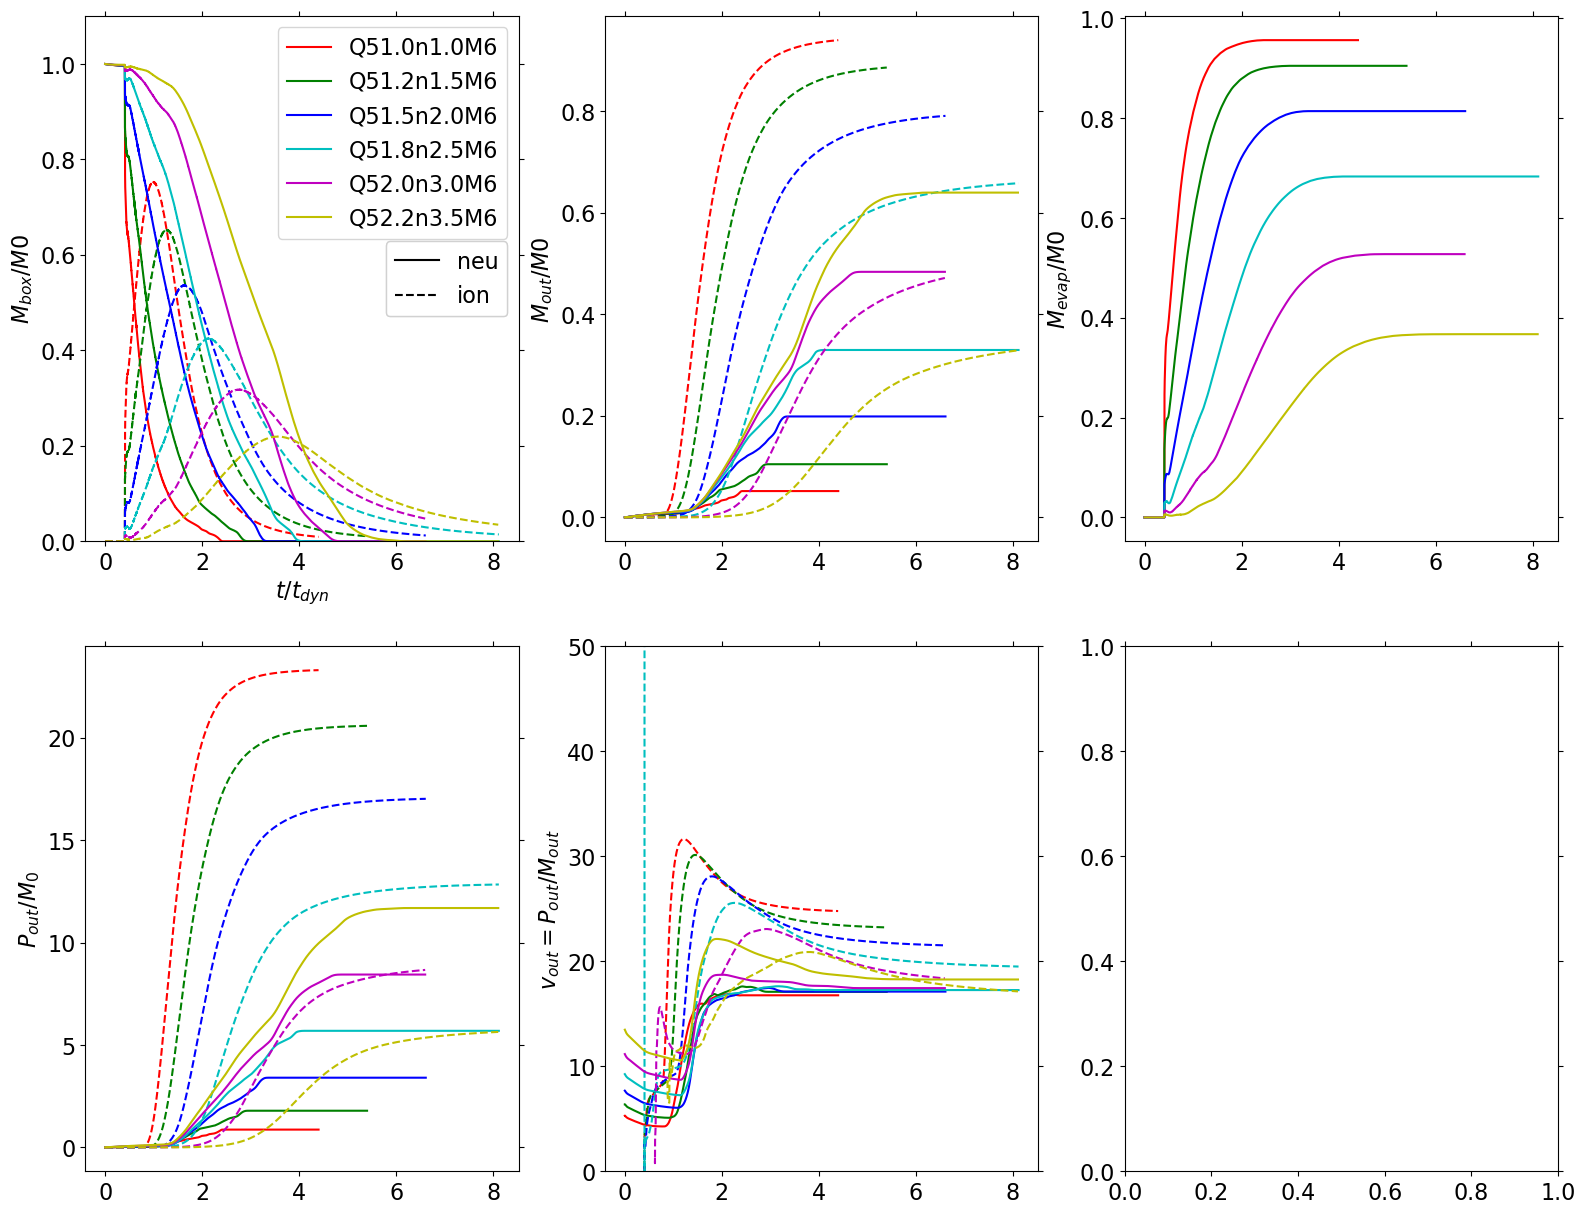

In [6]:
s=pa.LoadSim(str(M5[0]))
D5=hists(M5)
D6=hists(M6)
D5['Sig']=D5['Sig']*s.u.mass
D6['Sig']=D6['Sig']*s.u.mass

In [30]:
D5['Qi_eff']=[]
D6['Qi_eff']=[]
for model in M5:
    s=pa.LoadSim(str(model))
    h=pa.read_hst(s.files['hst'])
    ti=np.array(h['time'])
    dt=ti[1:]-ti[:-1]
    dt=np.hstack([dt,dt[-1]])
    qi_eff=np.array(h['qi_eff'])
    t_start=s.par['problem']['t0_src']
    t_dest=ti[h['mass_ion']>=0.05][-1]
    ind=np.where((ti>=t_start)&(ti<=t_dest))
    D5['Qi_eff'].append(np.sum(qi_eff[ind]*dt[ind])/np.sum(dt[ind]))
for model in M6:
    s=pa.LoadSim(str(model))
    h=pa.read_hst(s.files['hst'])
    ti=np.array(h['time'])
    dt=ti[1:]-ti[:-1]
    dt=np.hstack([dt,dt[-1]])
    qi_eff=np.array(h['qi_eff'])
    t_start=s.par['problem']['t0_src']
    t_dest=ti[h['mass_ion']>=0.05][-1]
    ind=np.where((ti>=t_start)&(ti<=t_dest))
    D6['Qi_eff'].append(np.sum(qi_eff[ind]*dt[ind])/np.sum(dt[ind]))

## scaling relation

In [31]:
def M_dot_scale(models,mode=None):
    x_arr,x_w_arr,val_arr,val_w_arr,scale_arr,scale_w_arr=np.array([]),np.array([]),np.array([]),np.array([]),np.array([]),np.array([])
    if mode == 'plot':
        fig,axes=plt.subplots(3,2,figsize=(15,23))    
    for model in models:
## model data load
        s=pa.LoadSim(str(model))
        h=pa.read_hst(s.files['hst'])
        hd=load_hd(str(model))    

## proper combination of Qi and nH0 for relation.
        Qi49=s.par['problem']['Qi']*hd['f_eff']/1e49
        n2=hd['n_ion_rms']/1e2
        x=Qi49**(2/3)/n2**(1/3)
        x[~(x>0)]=0
        Ti4=s.par['photchem']['tgas_HII']
## plot mass outflow rate
        M_out_scale=4.99*1000*x*Ti4**1.04*hd['f_wind']
        M_out=hd['M_out_ion']*s.u.mass/s.u.time
        if mode == 'plot':
            axes[0][0].loglog(x,M_out,label=str(model).split('/')[-1])
            axes[0][1].semilogx(x,M_out/M_out_scale,label=str(model).split('/')[-1])
            t_ff=t_ff_(str(model))

## additinal plot for f_wind, v_ej, etc... as functions of x or time.
            axes[1][0].semilogx(x,hd['f_wind'])
            axes[1][1].semilogx(x,hd['P_out_ion']/hd['M_out_ion'])
            axes[2][0].semilogy(hd['time']/t_ff,Qi49**(2/3)*n2**(-1/3))
            axes[2][1].plot(hd['time']/t_ff,hd['P_out_ion']/hd['M_out_ion'])
            #axes[1][1].semilogx(Qi49**(2/3)*n2**(-1/3),hd['vr_w_mass'])

## average method - simple time-average(weights = dt)
## select time interval for integration.
## t_dest=t_{ion,5%}, t_start=t0_src
        t_dest=np.array(h['time'][h['mass_ion']/h['mass'][0]>=0.05])[-1]
        t_start=s.par['problem']['t0_src']
        #t_dest=s.par['time']['tlim']
        #t_start=(hd['time'])[hd['M_out_ion']==np.max(hd['M_out_ion'])]

        ind=(hd['time']<=t_dest)&(hd['time']>=t_start)
        ti=hd['time']
        dt=(ti[ind])[1:]-(ti[ind])[:-1]
        dt=np.hstack([dt,dt[-1]])
        #dMevs,Mevs=t_sample(hd['time'],np.array(h['time']),np.array(h['dot_mass_ion_sphere']),'derivative')
        w=dt
        x_arr=np.hstack([x_arr,np.sum(x[ind]*w)/(np.sum(w))])
        val_arr=np.hstack([val_arr,np.sum(((hd['M_out_ion']*s.u.mass/s.u.time).value)[ind]*w)/(np.sum(w))])
        scale_arr=np.hstack([scale_arr,np.sum(M_out_scale[ind]*w)/(np.sum(w))])

## average method - weights=dot{M}_{out}. no need to select time interval.        
        dt=ti[1:]-ti[:-1]
        dt=np.hstack([dt,dt[-1]])
        w=hd['M_out_ion']*dt
        x_w_arr=np.hstack([x_w_arr,np.sum(x*w)/(np.sum(w))])
        val_w_arr=np.hstack([val_w_arr,np.sum(((hd['M_out_ion']*s.u.mass/s.u.time).value)*w)/(np.sum(w))])
        scale_w_arr=np.hstack([scale_w_arr,np.sum(M_out_scale*w)/(np.sum(w))])

## figure setting
    if mode == 'plot':
        axes[2][0].set_xlabel('$t/t_{dyn}$')
        axes[2][0].set_ylabel('$f_{wind}$')
        #x=Qi49^(2/3)*n^(-1/3)
        x=np.logspace(-1,2,100)
        M_out_scale=4.99*1000*x*0.8**1.04
        axes[0][0].loglog(x,M_out_scale,'--')
        axes[0][0].loglog(x_arr,val_arr,'k*',ms=10)
        axes[0][1].semilogx(x_arr,val_arr/scale_arr,'k*',ms=10)
        axes[0][0].loglog(x_w_arr,val_w_arr,'r*',ms=10)
        axes[0][1].semilogx(x_w_arr,val_w_arr/scale_w_arr,'r*',ms=10)
        axes[0][0].set_xlabel('$Q_{i,eff}^{2/3}n_{rms,ion}^{-1/3}$')
        axes[0][0].set_ylabel('$\dot{M}_{out,ion}$')
        axes[0][1].set_ylabel('$\dot{F}_M$')
        axes[1][1].set_ylabel('$v_{r}(r_{cl})$')
        axes[0][0].set_xlim(1e-1,1e2)
        axes[0][0].set_ylim(1e+3,1e6)
        axes[0][1].set_xlim(1e-1,1e2)
        axes[0][1].set_ylim(0,3)
        axes[1][0].set_xlim(1e-1,1e2)
        axes[1][1].set_xlim(1e-1,1e2)
        axes[1][1].set_ylim(0,30)
        axes[2][1].set_ylim(0,30)
        
    return x_arr,val_arr,scale_arr,x_w_arr,val_w_arr,scale_w_arr

<>:71: SyntaxWarning: invalid escape sequence '\d'
<>:72: SyntaxWarning: invalid escape sequence '\d'
<>:71: SyntaxWarning: invalid escape sequence '\d'
<>:72: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_1435240/2223362080.py:71: SyntaxWarning: invalid escape sequence '\d'
  axes[0][0].set_ylabel('$\dot{M}_{out,ion}$')
/tmp/ipykernel_1435240/2223362080.py:72: SyntaxWarning: invalid escape sequence '\d'
  axes[0][1].set_ylabel('$\dot{F}_M$')


In [11]:
x_arr,val_arr,scale_arr,x_w_arr,val_w_arr,scale_w_arr=M_dot_scale(M5)
x_arr2,val_arr2,scale_arr2,x_w_arr,val_w_arr2,scale_w_arr2=M_dot_scale(M6)

### In this part, the first change is that t_dest was corrected.
### Before, there were no-post processed data file at restart model.
### You can see this change the absolute values of outflow at high-density models
### Nevertheless, F value were not changed, so it can't effect on our last discussion.
### The second change is that f_wind was reflected on scaled outflow mass
### $-> \dot{M}_{scale} = 4\pi f_{wind} r_{0}^2 \rho_{rms} c_i^2$
### By considering this, we expect larger F value.

<>:5: SyntaxWarning: invalid escape sequence '\d'
<>:6: SyntaxWarning: invalid escape sequence '\d'
<>:8: SyntaxWarning: invalid escape sequence '\S'
<>:9: SyntaxWarning: invalid escape sequence '\d'
<>:10: SyntaxWarning: invalid escape sequence '\d'
<>:5: SyntaxWarning: invalid escape sequence '\d'
<>:6: SyntaxWarning: invalid escape sequence '\d'
<>:8: SyntaxWarning: invalid escape sequence '\S'
<>:9: SyntaxWarning: invalid escape sequence '\d'
<>:10: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_2245738/1132976506.py:5: SyntaxWarning: invalid escape sequence '\d'
  axes[0].semilogx(D6['Sig'],val_arr2,'b*',ms=10,label='$\dot{M}_{out}$')
/tmp/ipykernel_2245738/1132976506.py:6: SyntaxWarning: invalid escape sequence '\d'
  axes[0].semilogx(D6['Sig'],scale_arr2,'r*',ms=10,label='$\dot{M}_{scale}=4\pi f_{wind} r_{cl}^2 \\rho_{rms} c_i$')
/tmp/ipykernel_2245738/1132976506.py:8: SyntaxWarning: invalid escape sequence '\S'
  axes[0].set_xlabel('$\Sigma(M_{sun}/pc^2$')
/tmp/ipyk

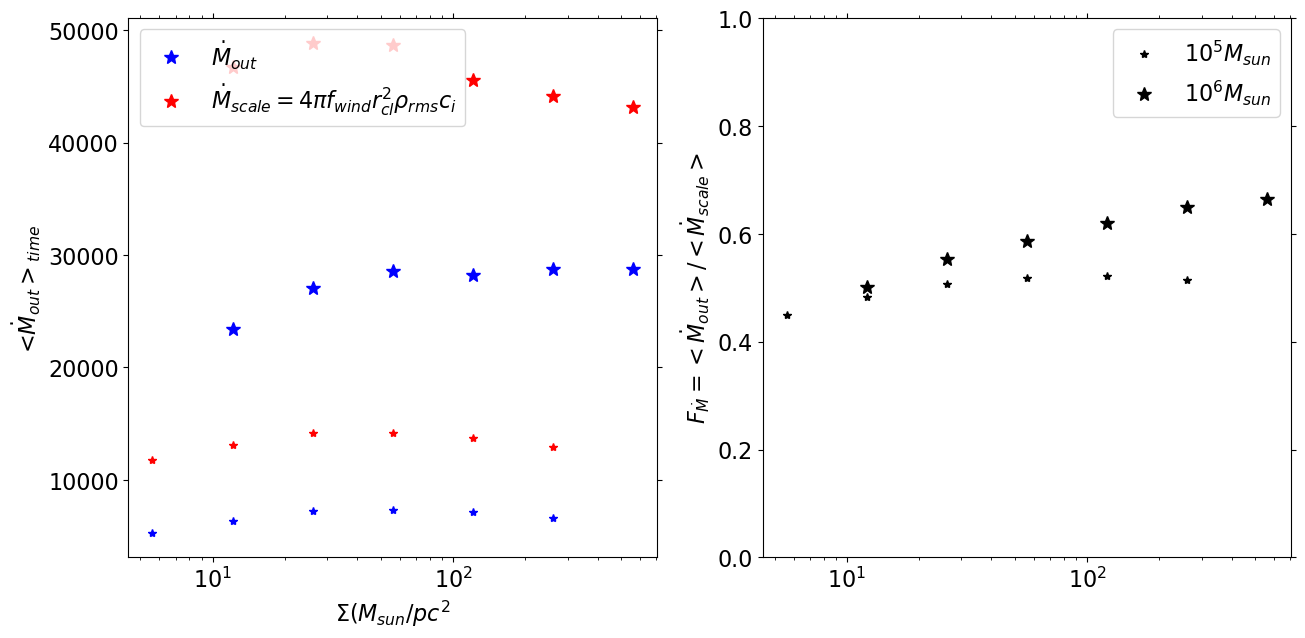

In [12]:
fig,axes=plt.subplots(1,2,figsize=(15,7))
axes[0].semilogx(D5['Sig'],val_arr,'b*',ms=6)
axes[0].semilogx(D5['Sig'],scale_arr,'r*',ms=6)
axes[1].semilogx(D5['Sig'],val_arr/scale_arr,'k*',ms=6,label='$10^5M_{sun}$')
axes[0].semilogx(D6['Sig'],val_arr2,'b*',ms=10,label='$\dot{M}_{out}$')
axes[0].semilogx(D6['Sig'],scale_arr2,'r*',ms=10,label='$\dot{M}_{scale}=4\pi f_{wind} r_{cl}^2 \\rho_{rms} c_i$')
axes[1].semilogx(D6['Sig'],val_arr2/scale_arr2,'k*',ms=10,label='$10^6M_{sun}$')
axes[0].set_xlabel('$\Sigma(M_{sun}/pc^2$')
axes[0].set_ylabel('<$\dot{M}_{out}>_{time}$')
axes[1].set_ylabel('$F_{\dot{M}}=<\dot{M}_{out}>/<\dot{M}_{scale}>$')
axes[0].legend()
axes[1].set_ylim(0,1)

axes[1].legend()

### There were increasing tendency in F value, which may suggest that
### the higher the cloud density, the more narrow the outflow region at r_cl, which means remains of neutral clumps.
### then, was our last discussion wrong?(in high-density clouds, outflow velocity is slow.)
### Seeing the result of radial momentum outflow, it seems not true. there is still the decreasing tendency.
### From this, the conclusion we can get is...
### in low density cloud: there were no change caused by including f_wind -> outflow occurs without resistence of neutral gas
### in high density cloud: there were big increase caused by including f_wind -> outflow occurs only through 'holes', which we want to capture

<>:3: SyntaxWarning: invalid escape sequence '\d'
<>:3: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_2245738/324209104.py:3: SyntaxWarning: invalid escape sequence '\d'
  plt.ylabel('$F_{\dot{M}}=<\dot{M}_{out}>/<\dot{M}_{scale}>$')


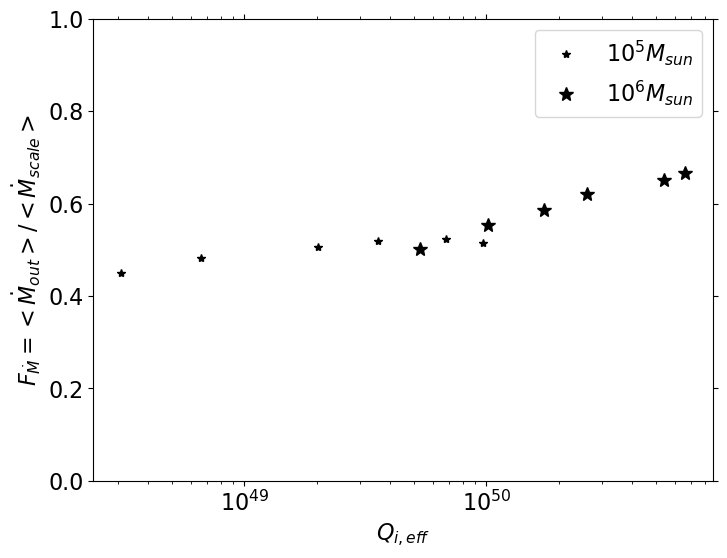

In [13]:
plt.semilogx(D5['Qi_eff'],val_arr/scale_arr,'k*',ms=6,label='$10^5M_{sun}$')
plt.semilogx(D6['Qi_eff'],val_arr2/scale_arr2,'k*',ms=10,label='$10^6M_{sun}$')
plt.ylabel('$F_{\dot{M}}=<\dot{M}_{out}>/<\dot{M}_{scale}>$')
plt.ylim(0,1)
plt.xlabel('$Q_{i,eff}$')
plt.legend()

In [21]:
def P_dot_scale(models,mode=None):
    x_arr,val_arr,scale_arr,x_w_arr,val_w_arr,scale_w_arr=np.array([]),np.array([]),np.array([]),np.array([]),np.array([]),np.array([])
    
    Ti4=0.8
    if mode == 'plot':
        fig,axes=plt.subplots(1,2,figsize=(15,7))
    for model in models:
## model data load
        s=pa.LoadSim(str(model))
        h=pa.read_hst(s.files['hst'])
        hd=load_hd(s.basedir)

## proper combination for scaling relation.
        Qi49=s.par['problem']['Qi']*hd['f_eff']/1e49
        n2=hd['n_ion_rms']/1e2
        x=Qi49**(2/3)*n2**(-1/3)
        x[~(x>0)]=0

## radial momentum outflow and scaling relation.
        P_dot_scale=5.55*10000*x*Ti4**1.54*hd['f_wind']
        P_out = hd['P_out_ion']*s.u.mass/s.u.time
        if mode == 'plot':
            axes[0].loglog(Qi49**(2/3)*n2**(-1/3),P_out,label=title_(str(model),['Q','n','M']))
            axes[1].semilogx(Qi49**(2/3)*n2**(-1/3),P_out/P_dot_scale)

## average method - simple time averaged value(weights = dt)
## selection time interval for integration.
        t_dest=np.array(h['time'][h['mass_ion']/h['mass'][0]>=0.05])[-1]
        t_start=s.par['problem']['t0_src']
        #t_dest=s.par['time']['tlim']
        #t_start=(hd['time'])[hd['M_out_ion']==np.max(hd['M_out_ion'])]
        ind=(hd['time']<=t_dest)&(hd['time']>=t_start)
        ti=hd['time'][ind]
        dt=ti[1:]-ti[:-1]
        dt=np.hstack([dt,dt[-1]])
        #dMevs,Mevs=t_sample(hd['time'],np.array(h['time']),np.array(h['dot_mass_ion_sphere']),'derivative')
        #w=dMevs[ind]*dt
        w=dt
        x_arr=np.hstack([x_arr,np.sum(x[ind]*w)/(np.sum(w))])
        val_arr=np.hstack([val_arr,np.sum(((hd['P_out_ion']*s.u.mass/s.u.time).value)[ind]*w)/(np.sum(w))])
        scale_arr=np.hstack([scale_arr,np.sum(P_dot_scale[ind]*w)/(np.sum(w))])

## average method - weights = dot{P}_{out}
        ti=hd['time']
        dt=ti[1:]-ti[:-1]
        dt=np.hstack([dt,dt[-1]])
        w=hd['P_out_ion']*dt
        x_w_arr=np.hstack([x_w_arr,np.sum(x*w)/(np.sum(w))])
        val_w_arr=np.hstack([val_w_arr,np.sum(((hd['P_out_ion']*s.u.mass/s.u.time).value)*w)/(np.sum(w))])
        scale_w_arr=np.hstack([scale_w_arr,np.sum(P_dot_scale*w)/(np.sum(w))])
## figure setting
    if mode=='plot':
        x=np.logspace(-1,2,100)
        P_dot_scale=5.55*10000*x*Ti4**1.54
        axes[0].loglog(x,P_dot_scale,'--')
        axes[0].loglog(x_arr,val_arr,'k*',ms=10)
        axes[1].semilogx(x_arr,val_arr/scale_arr,'k*',ms=10)
        axes[0].loglog(x_w_arr,val_w_arr,'r*',ms=10)
        axes[1].semilogx(x_w_arr,val_w_arr/scale_arr,'r*',ms=10)
        axes[0].set_xlabel('$Q_{i,eff}^{2/3}n_{rms,ion}^{-1/3}$')
        axes[0].set_ylabel('$\dot{P}_{out,ion}$')    
        axes[0].set_xlim(1e-1,1e+2)
        axes[0].set_ylim(1e+2,1e+7)
        axes[1].set_ylim(0,3)
    return x_arr,val_arr,scale_arr,x_w_arr,val_w_arr,scale_w_arr

<>:61: SyntaxWarning: invalid escape sequence '\d'
<>:61: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_2245738/1659922383.py:61: SyntaxWarning: invalid escape sequence '\d'
  axes[0].set_ylabel('$\dot{P}_{out,ion}$')


In [22]:
x_arr,val_arr,scale_arr,x_w_arr,val_w_arr,scale_w_arr=P_dot_scale(M5)
x_arr2,val_arr2,scale_arr2,x_w_arr2,val_w_arr2,scale_w_arr2=P_dot_scale(M6)

<>:5: SyntaxWarning: invalid escape sequence '\d'
<>:6: SyntaxWarning: invalid escape sequence '\d'
<>:8: SyntaxWarning: invalid escape sequence '\S'
<>:9: SyntaxWarning: invalid escape sequence '\d'
<>:10: SyntaxWarning: invalid escape sequence '\d'
<>:5: SyntaxWarning: invalid escape sequence '\d'
<>:6: SyntaxWarning: invalid escape sequence '\d'
<>:8: SyntaxWarning: invalid escape sequence '\S'
<>:9: SyntaxWarning: invalid escape sequence '\d'
<>:10: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_2245738/3060304339.py:5: SyntaxWarning: invalid escape sequence '\d'
  axes[0].semilogx(D6['Sig'],val_arr2,'b*',ms=10,label='$\dot{P}_{out}$')
/tmp/ipykernel_2245738/3060304339.py:6: SyntaxWarning: invalid escape sequence '\d'
  axes[0].semilogx(D6['Sig'],scale_arr2,'r*',ms=10,label='$\dot{P}_{out,scale}=4\pi f_{wind} r_{cl}^2 \\rho_{rms} c_i^2$')
/tmp/ipykernel_2245738/3060304339.py:8: SyntaxWarning: invalid escape sequence '\S'
  axes[0].set_xlabel('$\Sigma(M_{sun}/pc^2)$')
/t

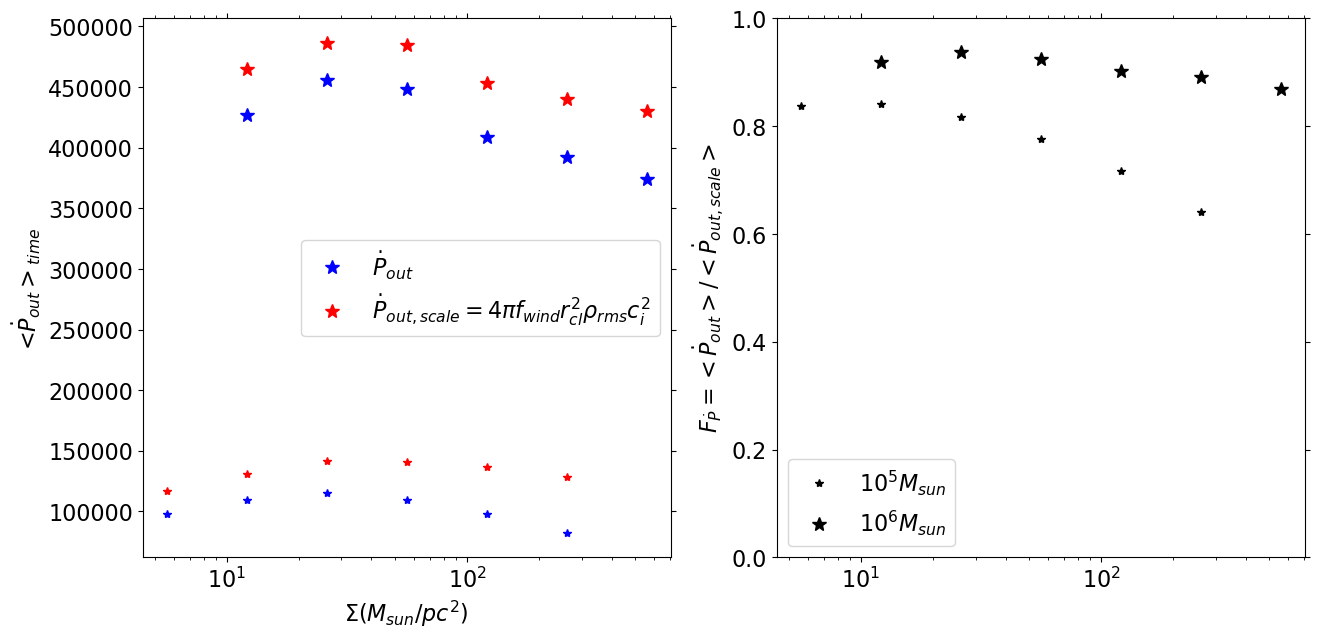

In [23]:
fig,axes=plt.subplots(1,2,figsize=(15,7))
axes[0].semilogx(D5['Sig'],val_arr,'b*',ms=6)
axes[0].semilogx(D5['Sig'],scale_arr,'r*',ms=6)
axes[1].semilogx(D5['Sig'],val_arr/scale_arr,'k*',ms=6,label='$10^5M_{sun}$')
axes[0].semilogx(D6['Sig'],val_arr2,'b*',ms=10,label='$\dot{P}_{out}$')
axes[0].semilogx(D6['Sig'],scale_arr2,'r*',ms=10,label='$\dot{P}_{out,scale}=4\pi f_{wind} r_{cl}^2 \\rho_{rms} c_i^2$')
axes[1].semilogx(D6['Sig'],val_arr2/scale_arr2,'k*',ms=10,label='$10^6M_{sun}$')
axes[0].set_xlabel('$\Sigma(M_{sun}/pc^2)$')
axes[0].set_ylabel('<$\dot{P}_{out}>_{time}$')
axes[1].set_ylabel('$F_{\dot{P}}=<\dot{P}_{out}>/<\dot{P}_{out,scale}>$')
axes[0].legend()
axes[1].set_ylim(0,1)

axes[1].legend()

### As mentioned above, after reflecting f_wind on scaling relation, there is still the decreasing tendency.

<>:3: SyntaxWarning: invalid escape sequence '\d'
<>:3: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_2245738/431160873.py:3: SyntaxWarning: invalid escape sequence '\d'
  plt.ylabel('$F_{\dot{P}}=<\dot{P}_{out}>/<\dot{P}_{scale}>$')


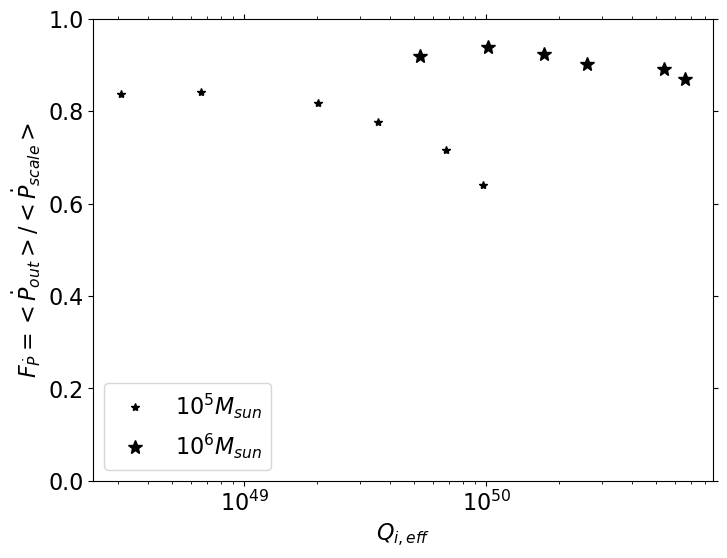

In [24]:
plt.semilogx(D5['Qi_eff'],val_arr/scale_arr,'k*',ms=6,label='$10^5M_{sun}$')
plt.semilogx(D6['Qi_eff'],val_arr2/scale_arr2,'k*',ms=10,label='$10^6M_{sun}$')
plt.ylabel('$F_{\dot{P}}=<\dot{P}_{out}>/<\dot{P}_{scale}>$')
plt.ylim(0,1)
plt.xlabel('$Q_{i,eff}$')
plt.legend()

In [19]:
#fig,axes=plt.subplots(1,2,figsize=(15,7))
Mev_arr,Pscale_arr,Mout_arr,P_arr,Pout_arr=[],[],[],[],[]

for model in M5+M6:
    s=pa.LoadSim(str(model))
    h=pa.read_hst(s.files['hst'])
    mev=np.array(h['dot_mass_ion'])
    mout=np.array(h['dot_mass_out_ion'])
    pbox=np.array(h['pr_ion'])#+h['pr_neu'])
    press=np.array(h['force_thm_ion'])#+h['force_thm_neu'])
    pout=np.array(h['dot_pr_out_ion'])#+h['dot_pr_out_neu'])
    Qieff=np.array(h['qi_eff'])
    nrms=np.array(np.sqrt(h['int_sqr_n_ion_dv']/h['vol_ion']))
    pout_scale=5.55*1e+4*(Qieff/1e49)**(2/3)*(nrms/1e2)**(-1/3)*0.8**1.54/(s.u.mass/s.u.time).value
    pout_scale[~(pout_scale>0)]=0
    ti=np.array(h['time'])
    dt=ti[1:]-ti[:-1]
    dt=np.hstack([dt,dt[-1]])

    tff=t_ff_(str(model))
    Press=integrate(dt,press)
    Pout=integrate(dt,pout)
    Mout=integrate(dt,mout)
    Pscale=integrate(dt,pout_scale)
    Mev=integrate(dt,mev)
    P_arr.append(Press[-1])
    Pout_arr.append(Pout[-1])
    Pscale_arr.append(Pscale[-1])
    Mout_arr.append(Mout[-1])
    Mev_arr.append(Mev[-1])
    #axes[1].plot(ti/tff,Pout)
    
    #axes[0].plot(ti/tff,Press,label=title_(str(model),['Q','n','M']))
#axes[0].legend()
#axes[0].set_xlabel('$t/t_{dyn}$')

<>:10: SyntaxWarning: invalid escape sequence '\S'
<>:10: SyntaxWarning: invalid escape sequence '\S'
/tmp/ipykernel_2245738/327161169.py:10: SyntaxWarning: invalid escape sequence '\S'
  axes[0].set_xlabel('$\Sigma(M_{sun}/pc^2$')
/tmp/ipykernel_2245738/327161169.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[1].legend()


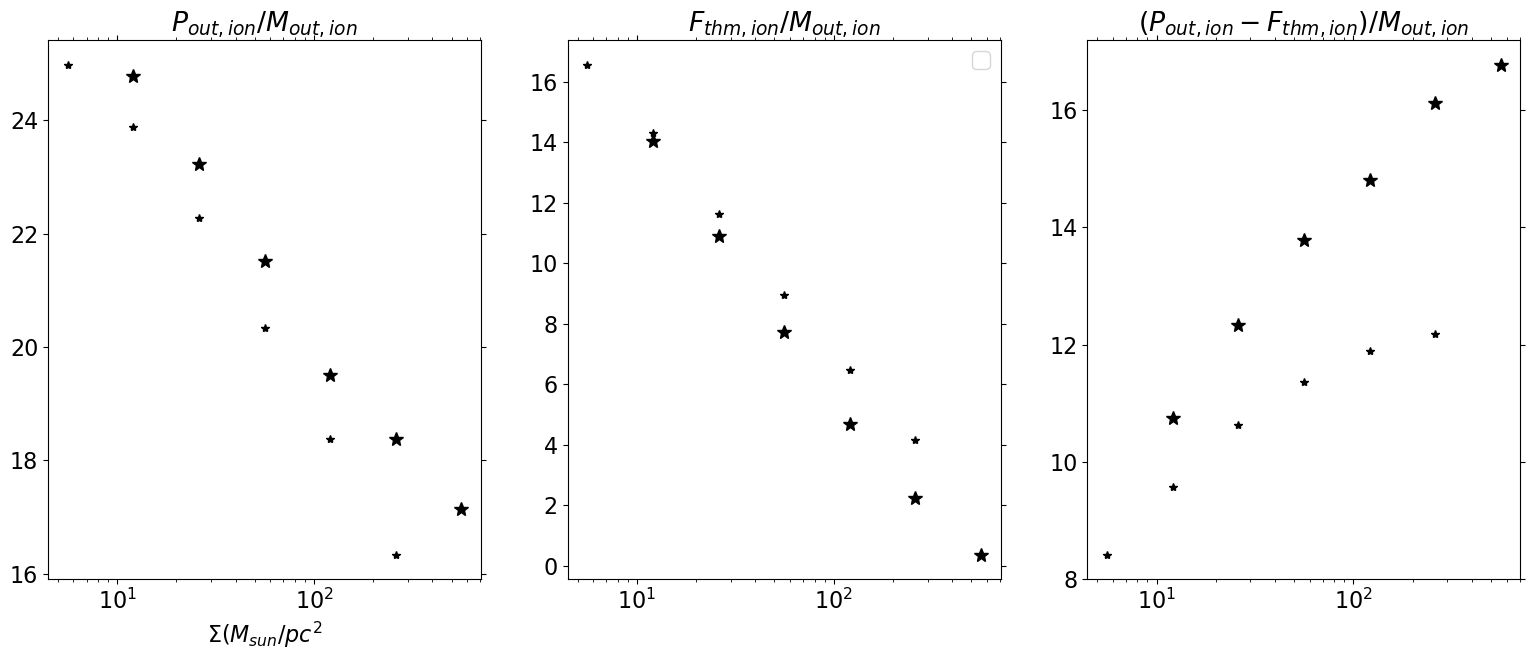

In [20]:
fig,axes=plt.subplots(1,3,figsize=(19,7))
axes[0].semilogx(D5['Sig'],np.array(Pout_arr)[:6]/np.array(Mout_arr)[:6],'k*',ms=6)
axes[1].semilogx(D5['Sig'],np.array(P_arr)[:6]/np.array(Mout_arr)[:6],'k*',ms=6)
axes[2].semilogx(D5['Sig'],(np.array(Pout_arr)-np.array(P_arr))[:6]/np.array(Mout_arr)[:6],'k*',ms=6)

axes[0].semilogx(D6['Sig'],np.array(Pout_arr)[6:]/np.array(Mout_arr)[6:],'k*',ms=10)
axes[1].semilogx(D6['Sig'],np.array(P_arr)[6:]/np.array(Mout_arr)[6:],'k*',ms=10)
axes[2].semilogx(D6['Sig'],(np.array(Pout_arr)-np.array(P_arr))[6:]/np.array(Mout_arr)[6:],'k*',ms=10)

axes[0].set_xlabel('$\Sigma(M_{sun}/pc^2)$')
axes[0].set_title('$P_{out,ion}/M_{out,ion}$')
axes[1].set_title('$F_{thm,ion}/M_{out,ion}$')
axes[2].set_title('$(P_{out,ion}-F_{thm,ion})/M_{out,ion}$')
axes[1].legend()

In [38]:
def M_scale(models,mode=None):
    Ti4=0.8
    x_arr,val_arr,scale_arr=np.array([]),np.array([]),np.array([])
    if mode == 'plot':
        fig,axes=plt.subplots(1,2,figsize=(15,7))
    for model in models:
## model data load
        s=pa.LoadSim(str(model))
        h=pa.read_hst(s.files['hst'])
        hd=load_hd(s.basedir)

## proper combination of Qi and nH0 for scaling.
        Qi49=s.par['problem']['Qi']*hd['f_eff']/1e49
        n2=hd['n_ion_rms']/1e2
        x=Qi49/n2
        x[~(x>0)]=0

## ion mass and its scaling relation
        M_scale=4.64*1e2*x*Ti4**0.82*hd['fV_ion']
        if mode == 'plot':
            axes[0].loglog(Qi49*n2**(-1),hd['M_sphere'],label=title_(str(model),['Q','n','M']))
            axes[1].semilogx(Qi49*n2**(-1),hd['M_sphere']/M_scale)
## average method - time averaged mass ion
        t_dest=np.array(h['time'][h['mass_ion']/h['mass'][0]>=0.05])[-1]
        #t_dest=s.par['time']['tlim']
        t_start=s.par['problem']['t0_src']
        #t_start=(hd['time'])[hd['M_out_ion']==np.max(hd['M_out_ion'])]
        ind=(hd['time']<=t_dest)&(hd['time']>=t_start)
        ti=hd['time'][ind]
        dt=ti[1:]-ti[:-1]
        dt=np.hstack([dt,dt[-1]])
        dMevs,Mevs=t_sample(hd['time'],np.array(h['time']),np.array(h['dot_mass_ion_sphere']),'derivative')
        #w=dMevs[ind]*dt
        w=dt
        x_arr=np.hstack([x_arr,np.sum(x[ind]*w)/(np.sum(w))])
        val_arr=np.hstack([val_arr,np.sum((hd['M_sphere'])[ind]*w)/(np.sum(w))])
        scale_arr=np.hstack([scale_arr,np.sum(M_scale[ind]*w)/(np.sum(w))])
    #figure setting
    if mode == 'plot':
        x=np.logspace(-1,2,100)
        M_scale=4.64*1e2*x*Ti4**0.82
        axes[0].loglog(x,M_scale,ls='--',lw=6,alpha=0.5)
        axes[0].loglog(x_arr,val_arr,'k*')
        axes[1].semilogx(x_arr,val_arr/scale_arr,'k*')
        axes[0].set_xlabel('$Q_{i,eff}n_{rms,ion}^{-1}$')
        axes[0].set_ylabel('${M}_{ion}$')    
        axes[0].set_xlim(1e-1,1e+4)
        axes[0].set_ylim(1e+2,1e+6)
        axes[1].set_ylim(0,2)
        axes[1].set_ylabel('$F_M$')
    return x_arr,val_arr,scale_arr

### the result of mass scaling relation was not changed afther the lass meeting.
### One thing to be discussed is, Can we say that low density clouds has more ionzied gas mass?
### As see history plot in data load cell, low density gas really has more ionized gas at t~t0_src, but by outflow, it rapidly decreases, and at t>>t0_src, high density gas has more ionized gas.
### In my opinion, the important thing is the difference between low and high density cloud, such as the ratio between t_ev and t_ej. it may explain the property in ion mass history.
### this is related the comment that the average value of ion mass seems to be meaningless.

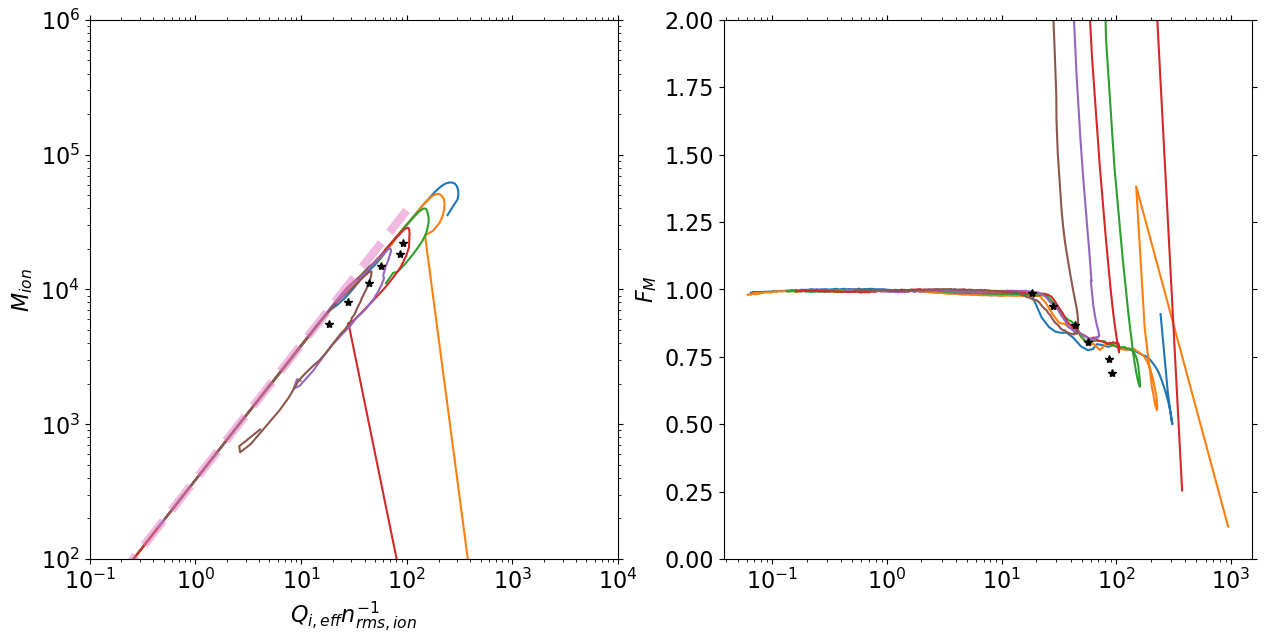

In [39]:
x_arr,val_arr,scale_arr=M_scale(M5,'plot')

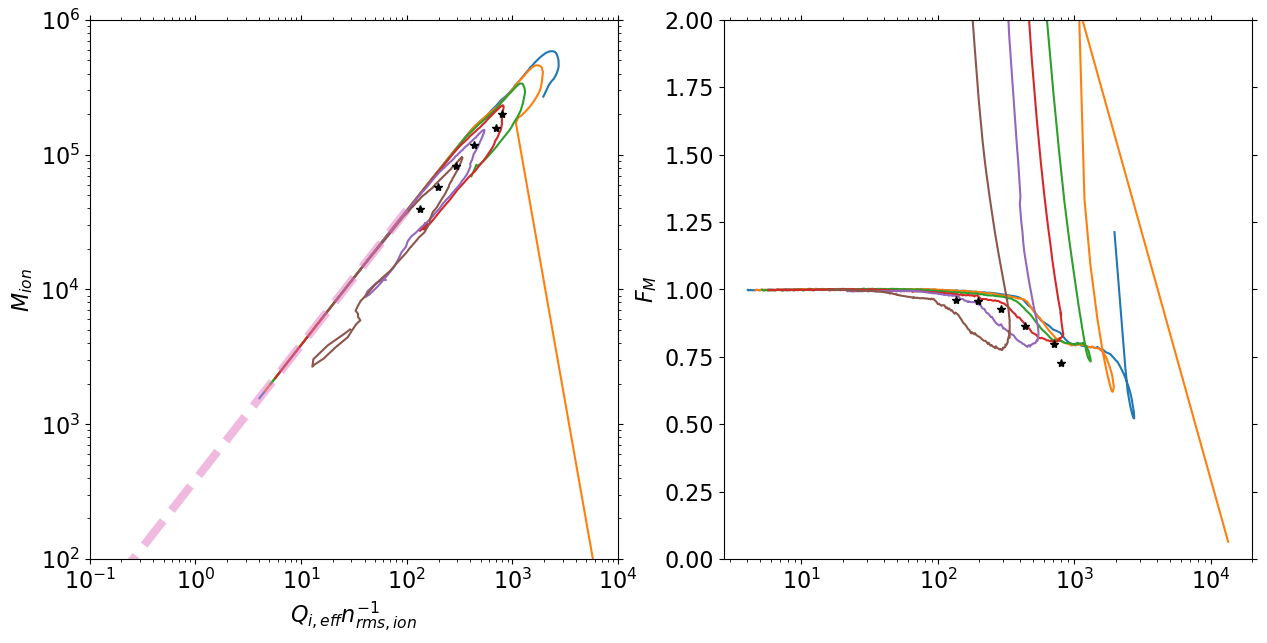

In [40]:
x_arr2,val_arr2,scale_arr2=M_scale(M6,'plot')

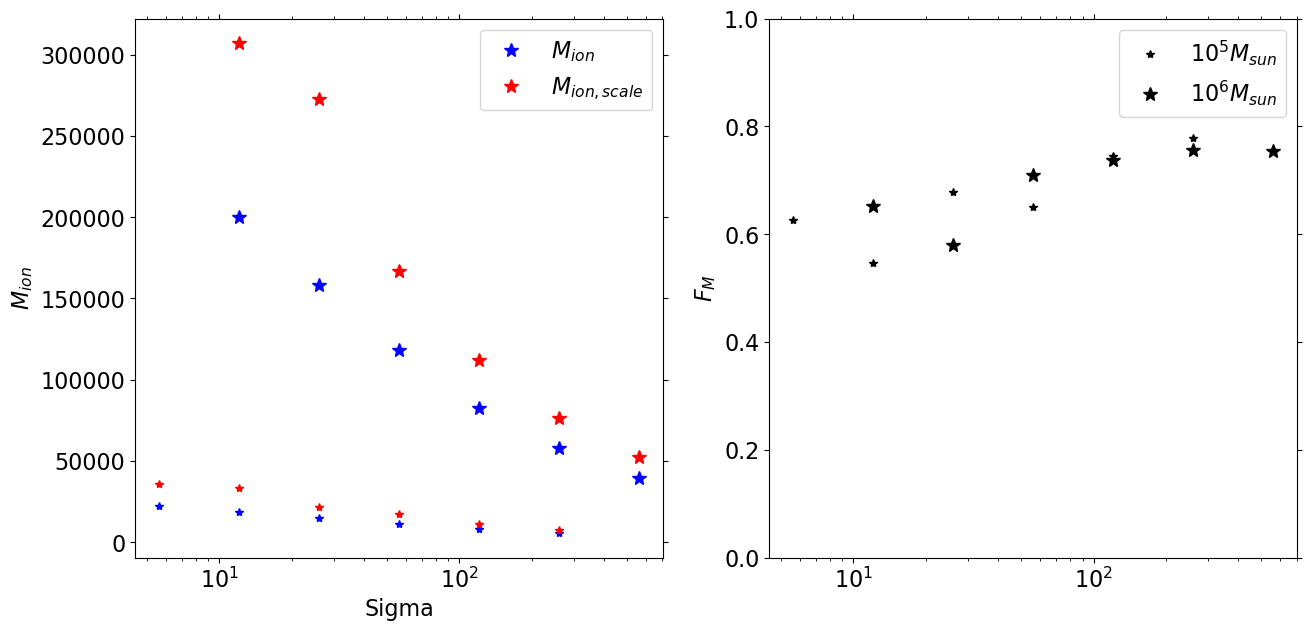

In [29]:
fig,axes=plt.subplots(1,2,figsize=(15,7))
axes[0].semilogx(D5['Sig'],val_arr,'b*',ms=6)
axes[0].semilogx(D5['Sig'],scale_arr,'r*',ms=6)
axes[1].semilogx(D5['Sig'],val_arr/scale_arr,'k*',ms=6,label='$10^5M_{sun}$')
axes[0].semilogx(D6['Sig'],val_arr2,'b*',ms=10,label='$M_{ion}$')
axes[0].semilogx(D6['Sig'],scale_arr2,'r*',ms=10,label='$M_{ion,scale}$')
axes[1].semilogx(D6['Sig'],val_arr2/scale_arr2,'k*',ms=10,label='$10^6M_{sun}$')
axes[0].set_xlabel('Sigma')
axes[0].set_ylabel('$M_{ion}$')
axes[1].set_ylabel('$F_{M}$')
axes[0].legend()
axes[1].set_ylim(0,1)

axes[1].legend()

In [43]:
def q_scale(models,mode=None):
    Ti4=0.8
    x_arr,val_arr,scale_arr=np.array([]),np.array([]),np.array([])
    if mode == 'plot':
        fig,axes=plt.subplots(2,2,figsize=(15,14))
    for model in models:
## model data load
        s=pa.LoadSim(str(model))
        h=pa.read_hst(s.files['hst'])
        hd=load_hd(s.basedir)
        ti=np.array(h['time'])
        ts=hd['time']
        
## proper combination of Qi and n for scaling relation. 
        Qi49=s.par['problem']['Qi']*hd['f_eff']/1e49
        n2=hd['n_ion_rms']/1e2
        x=Qi49**(1/3)*n2**(1/3)
        x[~(x>0)]=0

## shielding factor and its scaling relation.
        dMevs,Mevs = t_sample(ts,ti,np.array(h['dot_mass_ion_sphere']),arg='derivative')
        #dMevs = hd['M_out_ion']
        dNion=(dMevs/s.u.s/s.u.muH*s.u.cm**3)
        q_sh = Qi49*1e+49/dNion
        q_scale=74.6*x*Ti4**(-1.04)
        if mode == 'plot':
            axes[0][0].loglog(x,q_sh)
            axes[0][1].semilogy(ts/t_ff_(str(model)),Qi49**(1/3)*n2**(1/3))
            axes[1][0].semilogy(ts/t_ff_(str(model)),Qi49*1e+49)
            axes[1][1].semilogy(ts/t_ff_(str(model)),dNion)

## average method - evaporated mass - weighted average.
        #t_dest=np.array(h['time'][h['mass_ion']/h['mass'][0]>=0.05])[-1]
        #t_start=(hd['time'])[hd['M_out_ion']==np.max(hd['M_out_ion'])]
        t_start=s.par['problem']['t0_src']
        t_dest=s.par['time']['tlim']
        ind=(hd['time']<=t_dest)&(hd['time']>=t_start)

## exclude the snapshot at t~t0_src because of its extremely high value.
        for i in range(len(ind)):
            if ind[i] == True:
                ind[i]=False
                break
        ti=hd['time'][ind]
        dt=ti[1:]-ti[:-1]
        dt=np.hstack([dt,dt[-1]])
        #dMevs,Mevs=t_sample(hd['time'],np.array(h['time']),np.array(h['dot_mass_ion_sphere']),'derivative')
        w=dNion[ind]*dt
        #w=dt
        x_arr=np.hstack([x_arr,np.sum(x[ind]*w)/(np.sum(w))])
        val_arr=np.hstack([val_arr,np.sum(Qi49[ind]*dt*1e+49)/(np.sum(w))])
        scale_arr=np.hstack([scale_arr,np.sum(q_scale[ind]*w)/(np.sum(w))])
## figure setting
    if mode == 'plot':
        x=np.logspace(-3,3,200)
        q_scale=74.6*x*Ti4**(-1.04)
        axes[0][0].loglog(x,q_scale,'--')
        axes[0][0].loglog(x_arr,val_arr,'k*')
        axes[0][0].set_xlabel('$Q_{i,eff}^{1/3}n_{rms}^{1/3}$')
        axes[0][1].set_ylabel('$Q_{i,eff}^{1/3}n_{rms}^{1/3}$')
        axes[0][0].set_ylabel('$q_{shield}$')
        axes[0][0].set_xlim(1e-3,1e+2)
        axes[0][0].set_ylim(1,1e+6)
        axes[0][1].set_xlabel('$t/t_{ff}$')
        axes[1][0].set_ylabel('$Q_{i,eff}$')
        axes[1][1].set_ylabel('$\dot{N}_{ion}$')
    return x_arr,val_arr,scale_arr

<>:66: SyntaxWarning: invalid escape sequence '\d'
<>:66: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_2245738/1460866693.py:66: SyntaxWarning: invalid escape sequence '\d'
  axes[1][1].set_ylabel('$\dot{N}_{ion}$')


In [44]:
x_arr,val_arr,scale_arr=q_scale(M5)
x_arr2,val_arr2,scale_arr2=q_scale(M6)

<>:5: SyntaxWarning: invalid escape sequence '\m'
<>:6: SyntaxWarning: invalid escape sequence '\m'
<>:8: SyntaxWarning: invalid escape sequence '\S'
<>:5: SyntaxWarning: invalid escape sequence '\m'
<>:6: SyntaxWarning: invalid escape sequence '\m'
<>:8: SyntaxWarning: invalid escape sequence '\S'
/tmp/ipykernel_2245738/384674452.py:5: SyntaxWarning: invalid escape sequence '\m'
  axes[0].semilogx(D6['Sig'],val_arr2,'b*',ms=10,label='$q_{sh}=Q_{i,eff}/\mu_H \dot{M}_{evap}$')
/tmp/ipykernel_2245738/384674452.py:6: SyntaxWarning: invalid escape sequence '\m'
  axes[0].semilogx(D6['Sig'],scale_arr2,'r*',ms=10,label='$q_{sh,scale}=Q_{i,eff}/\mu_H \dot{M}_{scale}$')
/tmp/ipykernel_2245738/384674452.py:8: SyntaxWarning: invalid escape sequence '\S'
  axes[0].set_xlabel('$\Sigma(M_{sun}/pc^2)$')


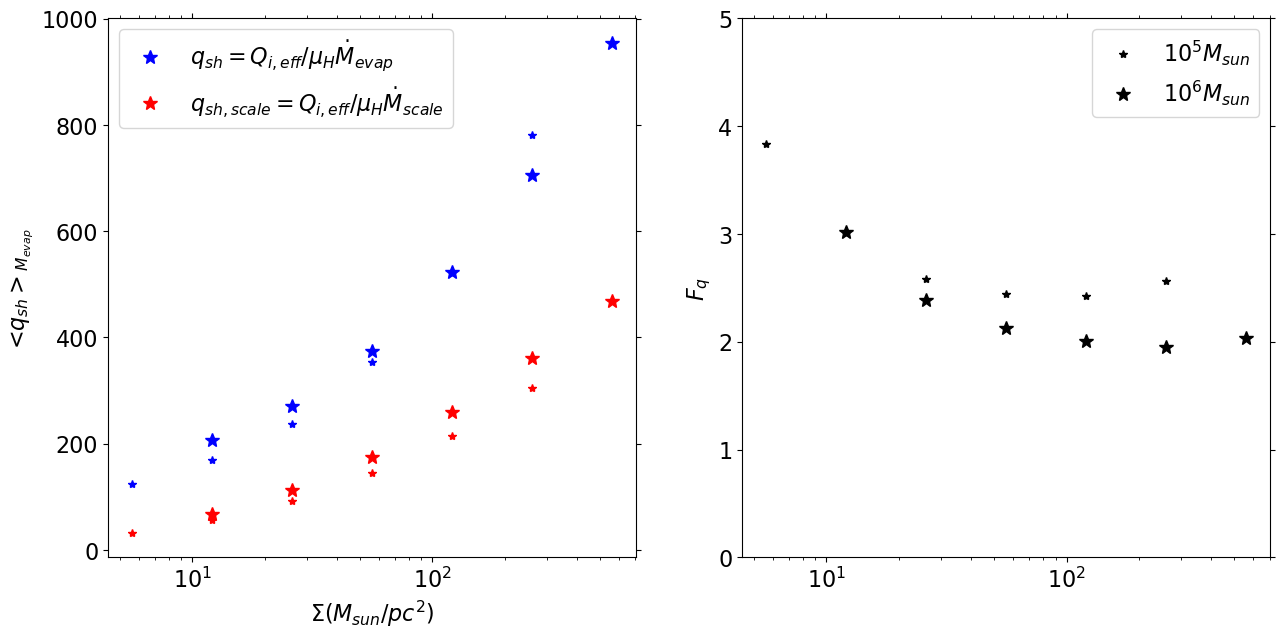

In [46]:
fig,axes=plt.subplots(1,2,figsize=(15,7))
axes[0].semilogx(D5['Sig'],val_arr,'b*',ms=6)
axes[0].semilogx(D5['Sig'],scale_arr,'r*',ms=6)
axes[1].semilogx(D5['Sig'],val_arr/scale_arr,'k*',ms=6,label='$10^5M_{sun}$')
axes[0].semilogx(D6['Sig'],val_arr2,'b*',ms=10,label='$q_{sh}=Q_{i,eff}/\mu_H \dot{M}_{evap}$')
axes[0].semilogx(D6['Sig'],scale_arr2,'r*',ms=10,label='$q_{sh,scale}=Q_{i,eff}/\mu_H \dot{M}_{scale}$')
axes[1].semilogx(D6['Sig'],val_arr2/scale_arr2,'k*',ms=10,label='$10^6M_{sun}$')
axes[0].set_xlabel('$\Sigma(M_{sun}/pc^2)$')
axes[0].set_ylabel('<$q_{sh}>_{M_{evap}}$')
axes[1].set_ylabel('$F_{q}$')
axes[0].legend()
axes[1].set_ylim(0,5)

axes[1].legend()

### As shown at the last meeting, Fq is really same FM_dot inverse, and it can may explain the converging tendency of FM

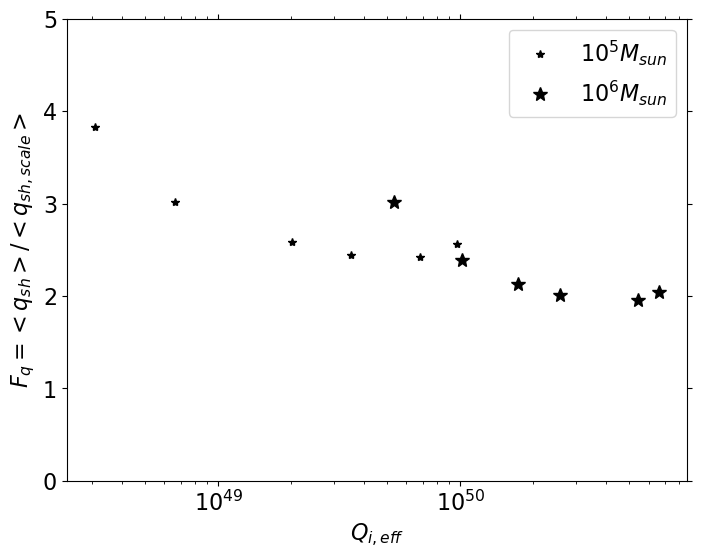

In [47]:
plt.semilogx(D5['Qi_eff'],val_arr/scale_arr,'k*',ms=6,label='$10^5M_{sun}$')
plt.semilogx(D6['Qi_eff'],val_arr2/scale_arr2,'k*',ms=10,label='$10^6M_{sun}$')
plt.ylabel('$F_{q}=<q_{sh}>/<q_{sh,scale}>$')
plt.ylim(0,5)
plt.xlabel('$Q_{i,eff}$')
plt.legend()

### t_ej vs t_evap

In [49]:
def timescale(model):
## model data load
    s=pa.LoadSim(str(model))
    h=pa.read_hst(s.files['hst'])
    hd=load_hd(str(model))

## limit time interval for integration   
    M0=h['mass'][0]
    ti=np.array(h['time'])
    t_dest=np.array(h['time'][h['mass_neu']/h['mass'][0]>=0.05])[-1]
    t_start=s.par['problem']['t0_src']
    #t_dest=s.par['time']['tlim']
    #t_start=(hd['time'])[hd['M_out_ion']==np.max(hd['M_out_ion'])]
    ind=(hd['time']<=t_dest)&(hd['time']>=t_start)
    ts=hd['time']
    dt=ts[1:]-ts[:-1]
    dt=np.hstack([dt,dt[-1]])
    dMevs,Mevs = t_sample(hd['time'],ti,np.array(h['dot_mass_ion_sphere']),arg='derivative')
    Mneu = t_sample(hd['time'],ti,np.array(h['mass_neu']))
    w=dt
    #w=dt*dMevs
## average mass evaporation rate : time-averaged value
    M_ev_avg=np.sum(dMevs[ind]*w[ind])/np.sum(w[ind])
    #M_ev_avg=np.sum(dMevs*dMevs*dt)/np.sum(dMevs*dt)

## characteristic evaporation time sacle
    t_ev_=Mevs[-1]/M_ev_avg

## characteristic ejection time sacle : how can one extract ejection velocity of neutral gas ejection not effected by photoionization feedback?
## in this, I just selected time interval t=0 ~ t=t0_src -> extract ejection velocity only by initial turbulence, expected to proportionate to t_ff
    ti=np.array(h['time'])
    pn_out=np.array(h['dot_pr_out_neu'])
    mn_out=np.array(h['dot_mass_out_neu'])

    pn_out,Pn_out=t_sample(ts,ti,pn_out,'derivative')
    mn_out,Mn_out=t_sample(ts,ti,mn_out,'derivative')
    
    vout=pn_out/mn_out
    #vout_=Pn_out[ts<=s.par['problem']['t0_src']][-1]/Mn_out[ts<=s.par['problem']['t0_src']][-1]
    vout_=Pn_out[-1]/Mn_out[-1]
    #r_cl=s.par['problem']['r0']*s.par['problem']['revap_over_r0']
    r_cl = s.par['mesh']['x1max']
    return ts[ind],Mneu[ind]/dMevs[ind],r_cl/vout[ind],r_cl/vout_,t_ev_,t_ff_(str(model))

In [50]:
t_ev_arr,t_ej_arr,t_ff_arr=np.array([]),np.array([]),np.array([])
color=['r','g','b','c','m','y']
#fig,axes=plt.subplots(1,2,figsize=(15,7))
for n, model in enumerate(M5[:]):
    ts,t_ev,t_ej,t_ej_avg,t_ev_avg,t_ff=timescale(model)
    #axes[0].semilogy(ts/ts[-1],t_ev,color[n]+'-')
    #axes[0].semilogy(ts/ts[-1],t_ej,color[n]+'--')
    t_ev_arr=np.hstack([t_ev_arr,t_ev_avg])
    t_ej_arr=np.hstack([t_ej_arr,t_ej_avg])
    t_ff_arr=np.hstack([t_ff_arr,t_ff])
#line1,=axes[0].plot([],[],'k-',label='$t_{evap}$')
#line2,=axes[0].plot([],[],'k--',label='$t_{ej}$')
#leg=axes[0].legend(handles=[line1,line2],loc='center left')
#axes[0].add_artist(leg)

In [51]:
t_ev_arr2,t_ej_arr2,t_ff_arr2=np.array([]),np.array([]),np.array([])
color=['r','g','b','c','m','y']
#fig,axes=plt.subplots(1,2,figsize=(15,7))
for n, model in enumerate(M6[:]):
    ts,t_ev,t_ej,t_ej_avg,t_ev_avg,t_ff=timescale(model)
    #axes[0].semilogy(ts/ts[-1],t_ev,color[n]+'-')
    #axes[0].semilogy(ts/ts[-1],t_ej,color[n]+'--')
    t_ev_arr2=np.hstack([t_ev_arr2,t_ev_avg])
    t_ej_arr2=np.hstack([t_ej_arr2,t_ej_avg])
    t_ff_arr2=np.hstack([t_ff_arr2,t_ff])
#line1,=axes[0].plot([],[],'k-',label='$t_{evap}$')
#line2,=axes[0].plot([],[],'k--',label='$t_{ej}$')
#leg=axes[0].legend(handles=[line1,line2],loc='center left')
#axes[0].add_artist(leg)

### In this part, I tried two method for comparison of t_ej and t_ev.
### One is to use P_out/M_out integrated for all time interval, and the result is in the below graph.
### The other is to use P_out/M_out integrated for t<t0_src, which means only considering the initial turbulence and pressure interaction between neutral gas, independently on photoioniztion.
### that result is in the second graph, and v_ej proportionate to v3d.

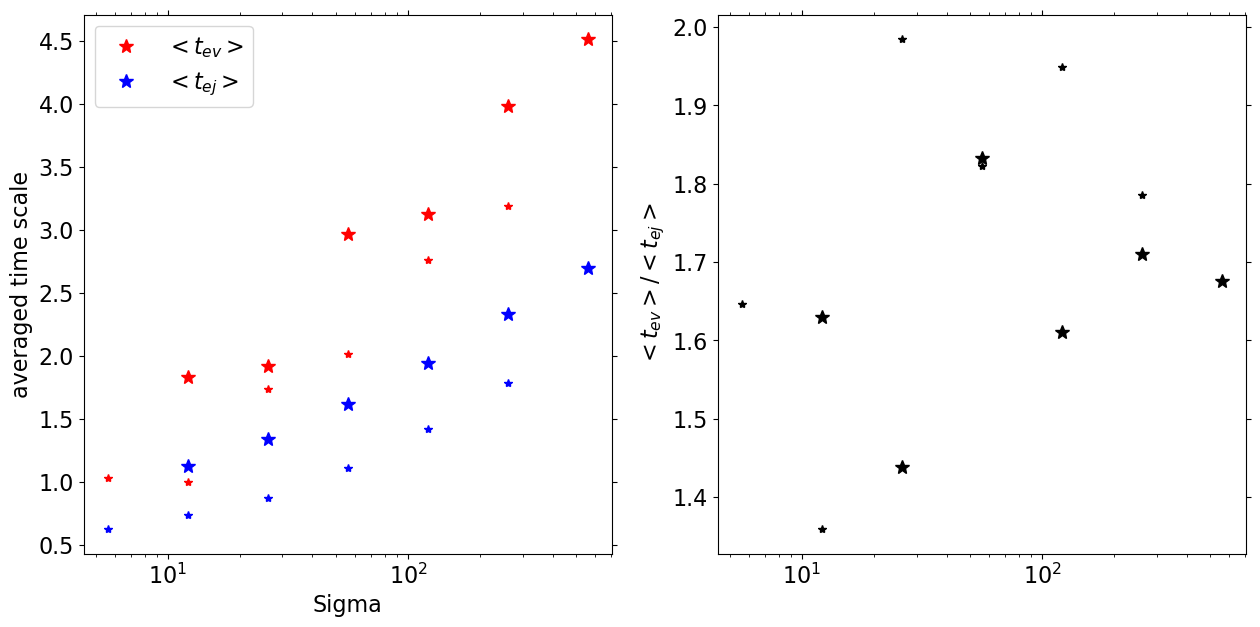

In [52]:
fig,axes=plt.subplots(1,2,figsize=(15,7))
axes[0].semilogx(D5['Sig'],t_ev_arr/t_ff_arr,'r*',ms=6)
axes[0].semilogx(D5['Sig'],t_ej_arr/t_ff_arr,'b*',ms=6)
axes[1].semilogx(D5['Sig'],t_ev_arr/t_ej_arr,'k*',ms=6,label='$10^5M_{sun}$')
axes[0].semilogx(D6['Sig'],t_ev_arr2/t_ff_arr2,'r*',ms=10,label='$<t_{ev}>$')
axes[0].semilogx(D6['Sig'],t_ej_arr2/t_ff_arr2,'b*',ms=10,label='$<t_{ej}>$')
axes[1].semilogx(D6['Sig'],t_ev_arr2/t_ej_arr2,'k*',ms=10,label='$10^6M_{sun}$')
axes[0].set_xlabel('Sigma')
axes[0].set_ylabel('averaged time scale')
axes[1].set_ylabel('$<t_{ev}>/<t_{ej}>$')
axes[0].legend()

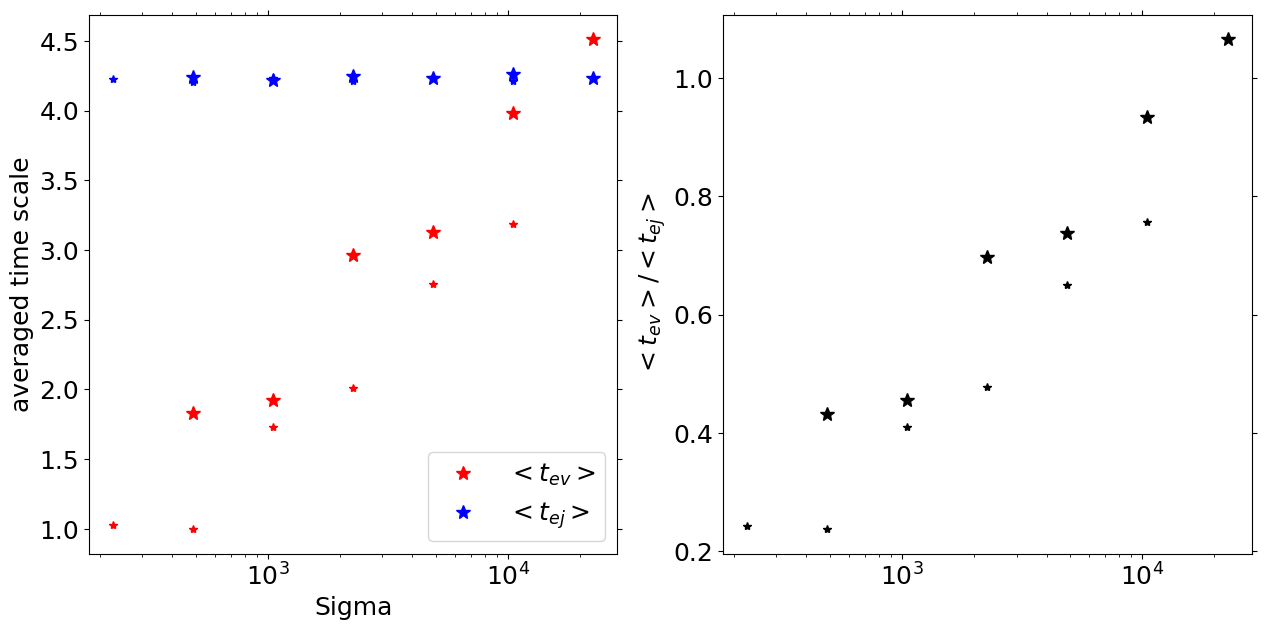

In [167]:
fig,axes=plt.subplots(1,2,figsize=(15,7))
axes[0].semilogx(D5['Sig'],t_ev_arr/t_ff_arr,'r*',ms=6)
axes[0].semilogx(D5['Sig'],t_ej_arr/t_ff_arr,'b*',ms=6)
axes[1].semilogx(D5['Sig'],t_ev_arr/t_ej_arr,'k*',ms=6,label='$10^5M_{sun}$')
axes[0].semilogx(D6['Sig'],t_ev_arr2/t_ff_arr2,'r*',ms=10,label='$<t_{ev}>$')
axes[0].semilogx(D6['Sig'],t_ej_arr2/t_ff_arr2,'b*',ms=10,label='$<t_{ej}>$')
axes[1].semilogx(D6['Sig'],t_ev_arr2/t_ej_arr2,'k*',ms=10,label='$10^6M_{sun}$')
axes[0].set_xlabel('Sigma')
axes[0].set_ylabel('averaged time scale')
axes[1].set_ylabel('$<t_{ev}>/<t_{ej}>$')
axes[0].legend()


### - high density cloud : large t_ej, small t_ev
### - low density cloud : small t_ej, large t_ev
### simple scaling based on the assumption almost evaporated mass escape from the domain. 
### -> at least, we can know $<\dot{M}_{ev}> = <\dot{M}_{out}>$
### $t_{ej} \sim r_0/v_{ej} \sim (M_0/n_{0})^{1/3}/v_{ej}, t_{ev} \sim M_{ev}/<\dot{M}_{ev}> \sim \epsilon_{evap}M_{0} Q_{i,eff}^{-2/3} n_{rms}^{1/3}$
### $ t_{ev}/t_{ej} \sim \epsilon_{evap}M_0^{2/3} v_{ej} Q_{i,eff}^{-2/3}n_0^{1/3} n_{rms}^{1/3}$


### Ionization parameter

In [7]:
## function to calculate ionization parameter===========================
def Ionization_parameter(model,nums=None):
## data load =============================================
    c=2.9979246*1e+5
    s=pa.LoadSim(str(model))
    hnu=s.par['photchem']['hnu[0]']*(1*yu.eV).to(yu.erg)
    h=pa.read_hst(s.files['hst'])

## selection of snapshots for calculation==================
    if nums == None:
        nums = range(0,s.nums[-1],20)
    U_arr,U_eq_arr,t_arr=[],[],[]
    Ti=s.par['photchem']['tgas_HII']
    sig_pi=s.par['photchem']['sigma_pi_HI[0]']
    sig_d=s.par['photchem']['sigma_d[0]']
## get U_pi and U_dust from the photochemistry values ======================
    Upi=2.82*10**(-6)*(Ti/10**4)**(-0.82)/(sig_pi/(3*10**(-18)))
    Ud=8.47*10**(-3)*(Ti/10**4)**(-0.82)/(sig_d/10**(-21))
    for num in nums:
        ds=s.load_hdf5(num,load_method='yt')
        t_arr.append(ds.current_time)
        add_fields(ds,s)

        r0=s.par['problem']['r0']*s.par['problem']['revap_over_r0']
        ad=ds.all_data()
## first, calculate U directly as n_phot = E_rad/hnu and U=n_phot/n_ion =====================
        r,ni,dV,xn=ad['radius'],ad['nH_ion'],ad['cell_volume'],ad['r0']
        n_phot=ad['Er_rayt0']*(s.u.energy/s.u.cm**3).value/hnu.value
        ind=(r<=r0)&(ad['r0']<=0.5)

        U_avg=np.sum(n_phot[ind]*ni[ind]*dV[ind])/np.sum(ni[ind]**2*dV[ind])
        U_arr.append(U_avg)
## second, calculate U with I=R equillibrium as U = U_pi (1-xn)^2/xn
        U_eq = Upi*(1-xn)**2/xn
        U_eq_avg=np.sum(ni[ind]**2*dV[ind]*U_eq[ind])/np.sum(ni[ind]**2*dV[ind])
        U_eq_arr.append(U_eq_avg)
    return Upi,Ud,np.array(t_arr), np.array(U_arr), np.array(U_eq_arr)

In [8]:
color=['r','g','b','c','m','y']
c=2.9979246*1e+5

alpha_B=2.59*1e-13*(s.par['photchem']['tgas_HII']/1e4)**(-0.7)

### You can see $<U>_{n^2} = f_{dust}/f_{ion}$ really.
### the average U shows two-phases. At t~t0_src, the higher density, the higher U. But, at t>>t0_src, the lower density, the higher U
### I tried to explain the cause of this tendency.

Text(0.5, 0, '$Q_{i,eff,49}n_{rms,ion}$')

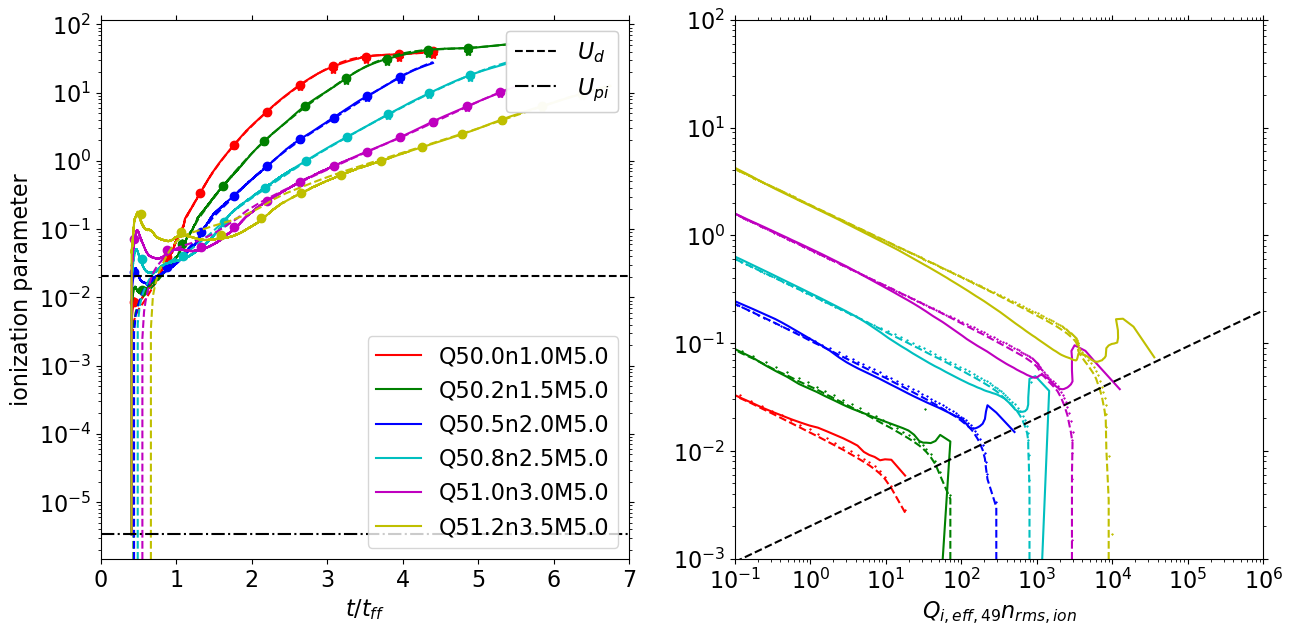

In [10]:
fig,axes=plt.subplots(1,2,figsize=(15,7))
handles=[]
for cind,model in enumerate(M5[:]):
## data load ===================================================
    model=str(model)
    s=pa.LoadSim(model)
    h=pa.read_hst(s.files['hst'])
    hd=load_hd(s.basedir)
    Upi,Ud,t_arr,U_arr,U_eq_arr=Ionization_parameter(model)
    t_ff=t_ff_(model)
## plot =======================================================
    ## solid line : f_dust/f_eff==============================================
    line,=axes[0].plot(h['time']/t_ff,h['qi_dust']/h['qi_eff']*Ud,color[cind]+'-',label=title_(model,['Q','n','M']))
    handles.append(line)
    ## o : direct calculation, * : indirect calculation with I=R equillibrium======================================
    axes[0].plot(t_arr/t_ff,U_arr,color[cind]+'o',ms=6)
    axes[0].plot(t_arr/t_ff,U_eq_arr,color[cind]+'*',ms=6)
## try a method in Draine 2011 ==================================================
    Q=s.par['problem']['Qi']
    n=hd['n_ion_rms']
    x=Q*hd['f_eff']/1e49*n
    axes[1].loglog(x,hd['f_dust']/hd['f_eff']*Ud,color[cind]+'-')
## U_ and U_2 = no dust case U from our simulation data====================================
   ## dashed line : about U_, (fixed) radius(=2r0) was expressed in terms of Qi_eff and n_rms===============================
    fV=hd['fV_ion']
    U_=fV**(2/3)*alpha_B**(2/3)/(c)*(3/4/np.pi)**(1/3)*(x*1e49)**(1/3)*(1*s.u.s/s.u.cm)*(1/hd['f_eff']-1/(4*fV))
    axes[1].loglog(x,U_,color[cind]+'--')
   ## * : about U_2, Qi_eff weren't used. radius was just fixed value================================
    R=2*s.par['problem']['r0']*s.u.cm
    U_2=3*Q/(4*np.pi*(c*1e5)*n*(R)**2)*(1-np.pi*alpha_B*n**2*R**3/(3*Q))
    axes[1].loglog(x,U_2,color[cind]+'*',ms=1)
    axes[0].plot(hd['time']/t_ff,U_,color[cind]+'--')

## finally, I plotted the simple scaling relation except for f_eff terms as black dashed line=======================
x=np.logspace(-1,7,100)
U_=alpha_B**(2/3)/c*(3/4/np.pi)**(1/3)*(x*1e49)**(1/3)*(1*s.u.s/s.u.cm)
axes[1].loglog(x,U_,'k--')

## figure setting ================================================
leg1=axes[0].legend(handles=handles,loc='lower right')
axes[0].add_artist(leg1)
line1,=axes[0].plot(np.linspace(0,8,100),np.ones(100)*Ud,color='k',ls='--',label='$U_d$')
line2,=axes[0].plot(np.linspace(0,8,100),np.ones(100)*Upi,color='k',ls='-.',label='$U_{pi}$')
leg2=axes[0].legend(handles=[line1,line2],loc='upper right')
axes[0].add_artist(leg2)
#ax.legend()
axes[0].set_xlabel('$t/t_{ff}$')
axes[0].set_yscale('log')
axes[0].set_xlim(0,7)
axes[0].set_ylabel('ionization parameter')
axes[1].set_xlim(1e-1,1e+6)
axes[1].set_ylim(1e-3,1e+2)
axes[1].set_xlabel('$Q_{i,eff,49}n_{rms,ion}$')

### First, I followed the derivation of no-dust case U in Draine 2011.
### For the case with spherical symmetry, I=R equillibrium, and no dust,
### ${d\phi \over dr} = -{4\pi n^2 \alpha_B \over Q_0}r^2 -> \phi(r)=(1-{Q_{eff}(r)\over Q_0})=(1-{4\pi n^2 \alpha_B\over 3Q_0}r^3)$
### By assuming uniform density, $n=n_{rms,ion}$, one can get the scaling relation of U.
### $ n_{phot}(r)={Q_0\phi \over 4\pi r^2 c}, <U>={3Q_0 \over 4\pi cn R^3}{\int_0^R \phi dr}$
### while $R= 2r_0 = ({3Q_{i,eff}(R)\over 4\pi \alpha_B n^2f_{V,ion}})^{1/3}$
### $<U> = {3Q_0 \over 4\pi cn R^2}(1-{\pi n^2 \alpha_B \over 3Q_0}R^3)$ -> plotted as * mark in the second plot
### By replacing R with n and Qi_eff
### $<U> = ({3\over 4\pi})^{1/3}f_{V,ion}^{2/3}{\alpha_B^{2/3}\over c}(Q_{i,eff} n)^{1/3}({1\over f_{eff}}-{1 \over 4f_{V,ion}})$-> dashed line in the second plot

### you can see that real Ionization parameter follows the expectation from spherically symmetric, uniform, and no-dust HII region model at t>>t0_src. 
### in fact, little dust aborption is a obvious result from f_dust history plot...
### Maybe, We can get similar scaling relation just by setting phi=1
### By the way, even at t~t0_src, it seems that low-density clouds are closer to no_dust case than high density clouds.
### Does it corresponds to that dust(and radiation pressure absent in this simulation) is more important in high density clouds at t~t0_src, even uniform density assumption breaks?


### getting a motivation from the above analysis, I tried to anlalyze t~t0_src phase and dusty model of HII regions.
### -> $Q_{i,eff} \sim {4\pi \over 3} r_{cl}^3n_{rms}^2 \alpha_{B}, Q_{i,dust} = \int c\sigma_d n_{phot} n_{ion} dV = c\sigma_d <n_{phot}>_{M_i}M_i$
### at t~t0_src, I=R equilibrium breaks.

### I tried to explain t>>t0_src case with uniform density & I-R equilibrium condition, including dust term.
### However, although this returns an analytic solution, it can't be scaled simply as a function of some observable varialbles.
### the process is ...
### ${d\phi \over dr}=-{1\over Q_0}\alpha_Bn^24\pi r^2-n\sigma_d\phi $
### $-> \phi(r) = A(r^2-{2r \over n\sigma_d} +{2 \over (n\sigma_d)^2})+Be^{-n\sigma_d r}, A={-4\pi\alpha_B n^2\over n\sigma_d Q_0}, B=1-{2A \over (n\sigma_d)^2}$
### $<n_{phot}>={3 \over 4\pi r^3}\int {Q_0\phi \over 4\pi r^2 c}dV={3 \over 4\pi r^3}{Q_0\over c}\int \phi dr$

<>:58: SyntaxWarning: invalid escape sequence '\s'
<>:58: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_1930893/1674586782.py:58: SyntaxWarning: invalid escape sequence '\s'
  axes[1][0].set_ylabel('$R_{st}*n\sigma_d$')


Text(0, 0.5, '$R_{st}*n\\sigma_d$')

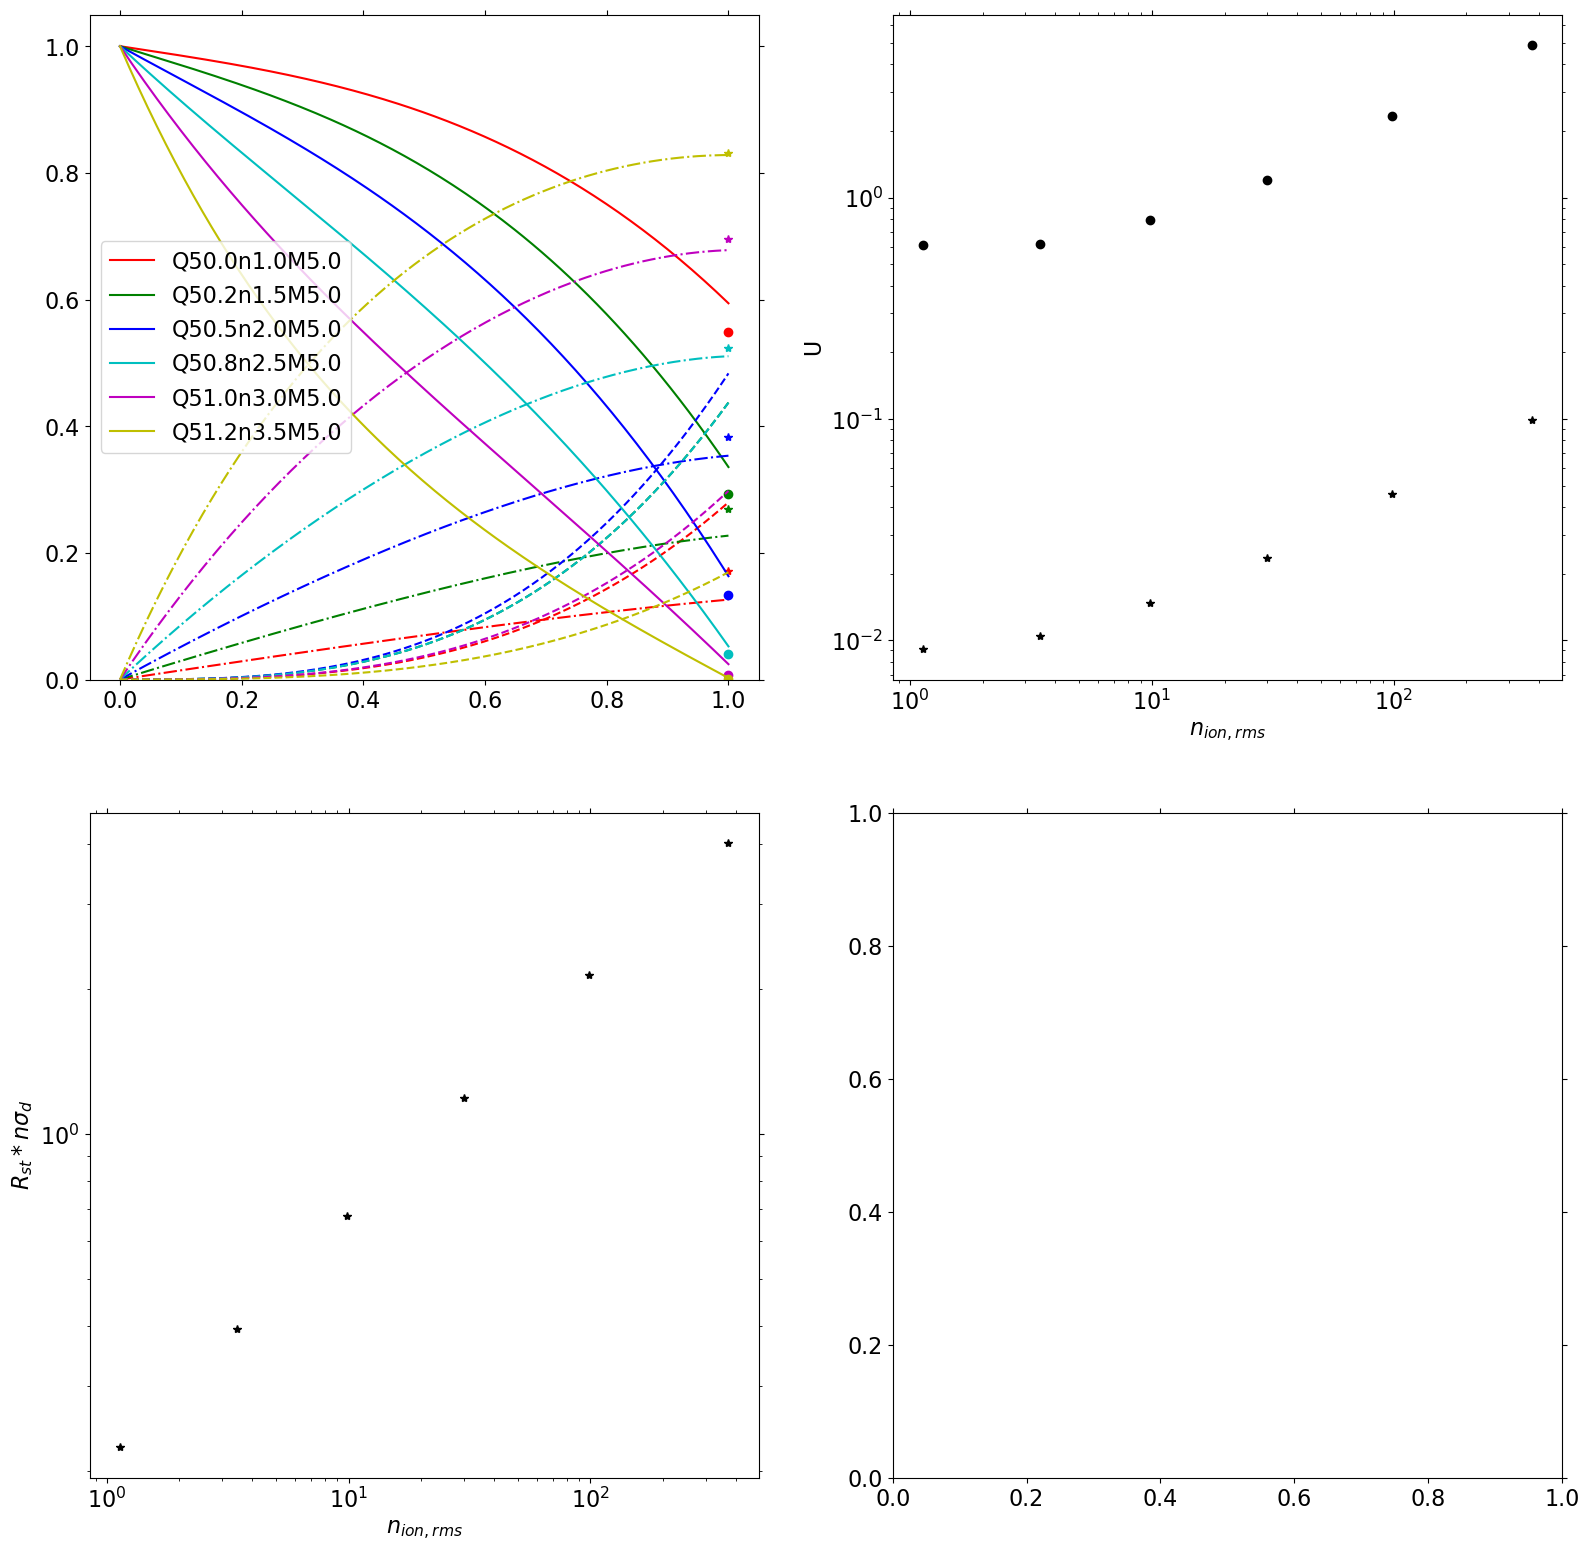

In [30]:
fig,axes=plt.subplots(2,2,figsize=(19,19))
color=['r','g','b','c','m','y']
handles=[]
for cind,model in enumerate(M5[:]):
## data load =================================================
    model=str(model)
    s=pa.LoadSim(model)
    sig_d=s.par['photchem']['sigma_d[0]']
    h=pa.read_hst(s.files['hst'])
    n_=np.array(np.sqrt(h['int_sqr_n_ion_dv']/h['vol_ion']))
    fV_ion=np.array(h['vol_ion']/(4*np.pi/3*(s.par['problem']['revap_over_r0']*s.par['problem']['r0'])**3))
    Q0=s.par['problem']['Qi']
    Qeff_=np.array(h['qi_eff'])
    Qdust_=np.array(h['qi_dust'])
## get one snapshot for calculation. I intentionally tried to early phase ==========================================
    ind=np.where(h['time']>=0.6*t_ff_(str(model)))[0]
    n,Qeff,Qdust,fV=n_[ind][0],Qeff_[ind][0],Qdust_[ind][0],fV_ion[ind][0]
## anlalytic solution from the theoretical model.==============================================
    A=-4*np.pi*alpha_B*n/sig_d/Q0
    B=1-2*A/(n*sig_d)**2
    ## notice that this is not fixed revap, which must include fV_ion!======================================
    rmax=(3*Qeff/(4*np.pi*alpha_B*n*n))**(1/3)
    r=np.linspace(0,rmax,200)
    ## phi(r), phi_eff(r), phi_dust(r) ================================================
    phi=A*(r**2-2*r/n/sig_d+2/(n*sig_d)**2)+B*np.e**(-n*sig_d*r)
    phi_eff=4*np.pi/3*alpha_B*n**2*r**3/Q0
    phi_dust=1-phi-phi_eff
    ##====================================================================
    r_st=(3*Q0/(4*np.pi*alpha_B*n**2))**(1/3)

    ## <n_phot> calculated from the analytic solution.========================================
    n_phot_avg=3*Q0/(4*np.pi*rmax**3*c*1e5)*(A*rmax**3*(1/3-1/(rmax*n*sig_d)+2/(rmax*n*sig_d)**2)+B/(n*sig_d)*(1-np.e**(-n*sig_d*rmax)))

## figure setting ========================================================================================
    ## phi(r): -, phi_eff(r): --, phi_dust(r): -. ================================================
    axes[0][0].plot(r/rmax,phi,color[cind],label=title_(model,['Q','n','M']))
    axes[0][0].plot(r/rmax,phi_eff,color[cind]+'--')
    axes[0][0].plot(r/rmax,phi_dust,color[cind]+'-.')
    
    ## measured values at r=2r_0 in simulation data ========================================
    ## phi: o, phi_dust: *
    axes[0][0].plot(1,1-(Qdust+Qeff)/Q0,color[cind]+'o')
    axes[0][0].plot(1,Qdust/Q0,color[cind]+'*')

## plot Ionization paramter as a function of n_ion_rms==============================================
    ## theoretical value: *, measured value from simulation: o
    axes[0][1].loglog(n,n_phot_avg/n,'k*')
    axes[0][1].loglog(n,Qdust/Qeff,'ko')

    
    axes[1][0].loglog(n,r_st*n*sig_d,'k*')

axes[0][0].legend(loc='center left')
axes[0][0].set_ylim(0,1.05)
axes[0][1].set_ylabel('U')
axes[0][1].set_xlabel('$n_{ion,rms}$')
axes[1][0].set_xlabel('$n_{ion,rms}$')
axes[1][0].set_ylabel('$R_{st}*n\sigma_d$')

### In the first panel, uniform density assumption returns similar values with simulation data. Its prediction power seems not so bad. But there are two problems.
### First, the first panel result is not considering fV_ion. thus $r_{max}$ is not fixed as 2r0. Rather, it is really a size of Spherical HII region.
### the reason why we get the better prediction by ignoring fV_ion may be originated from dust absorption of neutral gas in ionization front, which isn't considered at the theoretical model, but included in region r=2r0
### Second, although it may be just a mistake, expectation from models has values 50 times smaller values than simulation data. But, I have yet to find its cause.